In [1]:
from functools import reduce
from pandarallel import pandarallel

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import statsmodels.api as sm
import plotly.graph_objects as go
from csmarapi.CsmarService import CsmarService
from plotly.subplots import make_subplots

from utils.my_cache import cache_wrapper
from utils.functions import *

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
csmar = CsmarService()
pandarallel.initialize()

csmar.login('wuhh@pbcsf.tsinghua.edu.cn', 'whh8803582')

Fri 09 Dec 2022 16:08:43 connectionpool.py WARNING Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate in certificate chain (_ssl.c:997)'))': /api/csmar-main/login


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


Fri 09 Dec 2022 16:08:43 connectionpool.py WARNING Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate in certificate chain (_ssl.c:997)'))': /api/csmar-main/login
Fri 09 Dec 2022 16:08:43 connectionpool.py WARNING Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate in certificate chain (_ssl.c:997)'))': /api/csmar-main/login


MaxRetryError: HTTPSConnectionPool(host='cn.gtadata.com', port=443): Max retries exceeded with url: /api/csmar-main/login (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate in certificate chain (_ssl.c:997)')))

## **I. Data**

**Research**

- Most Data (nav/dividend/split ratio/asset allocation) : `CSMAR`

- Fund classification : `JoinQuant`

- Fund start date: `JoinQuant`

- SVC related: `previous research`

**Validation**

- `AMAC` : [2020 yearly report, page 15](https://www.amac.org.cn/researchstatistics/publication/zgzqtzjjynb/202104/t20210419_11390.html), for market statistic

- `Win.d` : classification/share/nav, for market statistic; stock fund adjusted net asset value (2005/6-2019/6)

<span style="color:blue">Data is sound, carefully verified and available to fetch</span>

## **II. Market Statistic**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from data.CSMAR.Fund_ShareChange import csmar_share_info
from data.JoinQuant.jq_all_fund_main_info import jq_all_fund_main_info
from data.TwoStepData.csmar_nav_monthly import csmar_nav_monthly
from data.Wind.wind_validate_share_nav import *
from data.AMAC.amac_full_market_value import amac_full_market_value
from utils.my_cache import cache_wrapper
from utils.functions import *

auth success 


split Win.d data

|       | share            | nav            |
| ----- | ---------------- | -------------- |
| all | all fund share | all fund nav |
| blend | blend fund share | blend fund nav |

In [ ]:
wind_validate_share = wind_validate_share_nav.loc['基金份额', slice(None)]
wind_validate_share.columns = wind_validate_share.columns.str.split('.').str[0]
wind_validate_share = wind_validate_share[ ~ wind_validate_share.index.duplicated(keep='last')]

In [ ]:
wind_validate_nav = wind_validate_share_nav.loc['单位净值', slice(None)]
wind_validate_nav.columns = wind_validate_nav.columns.str.split('.').str[0]
wind_validate_nav = wind_validate_nav[ ~ wind_validate_nav.index.duplicated(keep='last')]

In [ ]:
wind_stock_fund_share = wind_validate_share.T[(wind_fund_classification['投资类型(一级分类)'] == '股票型基金').values].T
wind_blend_fund_share = wind_validate_share.T[(wind_fund_classification['投资类型(一级分类)'] == '混合型基金').values].T

wind_stock_fund_nav = wind_validate_nav.T[(wind_fund_classification['投资类型(一级分类)'] == '股票型基金').values].T
wind_blend_fund_nav = wind_validate_nav.T[(wind_fund_classification['投资类型(一级分类)'] == '混合型基金').values].T

make Win.d data plottable

In [ ]:
wind_stock_fund_num = pd.notna(wind_stock_fund_nav).sum(axis=1)
wind_stock_fund_num.index = wind_stock_fund_num.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

wind_blend_fund_num = pd.notna(wind_blend_fund_nav).sum(axis=1)
wind_blend_fund_num.index = wind_blend_fund_num.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

wind_stock_fund_mkt_value = (wind_stock_fund_share * wind_stock_fund_nav).sum(axis=1)
wind_stock_fund_mkt_value.index  = wind_stock_fund_mkt_value.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

wind_blend_fund_mkt_value = (wind_blend_fund_share * wind_blend_fund_nav).sum(axis=1)
wind_blend_fund_mkt_value.index  = wind_blend_fund_mkt_value.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

align JoinQuant && CSMAR data

In [ ]:
csmar_share_info = csmar_share_info.drop_duplicates(subset=['Symbol', 'Date']).pivot(index='Date', columns='Symbol', values='EndDateShares')


In [ ]:
selected_month = 12

csmar_share_info_6 = csmar_share_info[csmar_share_info.index.month == selected_month]
csmar_nav_monthly_6 = csmar_nav_monthly[csmar_nav_monthly.index.month == selected_month]

csmar_blend_code_6 = np.intersect1d(csmar_nav_monthly_6.columns, jq_all_fund_main_info[jq_all_fund_main_info.underlying_asset_type == '混合型'].main_code.values)
csmar_blend_code_6 = np.intersect1d(csmar_blend_code_6, csmar_share_info_6.columns)

csmar_stock_code_6 = np.intersect1d(csmar_nav_monthly_6.columns, jq_all_fund_main_info[jq_all_fund_main_info.underlying_asset_type == '股票型'].main_code.values)
csmar_stock_code_6 = np.intersect1d(csmar_stock_code_6, csmar_share_info_6.columns)

csmar_co_time_6 = np.intersect1d(csmar_share_info_6.index, csmar_nav_monthly_6.index)


In [ ]:
csmar_blend_mkt_value_jq_classify = (csmar_share_info_6.loc[csmar_co_time_6, csmar_blend_code_6] * csmar_nav_monthly_6.loc[csmar_co_time_6, csmar_blend_code_6]).sum(axis=1)
csmar_stock_mkt_value_jq_classify = (csmar_share_info_6.loc[csmar_co_time_6, csmar_stock_code_6] * csmar_nav_monthly_6.loc[csmar_co_time_6, csmar_stock_code_6]).sum(axis=1)

csmar_stock_mkt_value_jq_classify.index = csmar_stock_mkt_value_jq_classify.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)
csmar_blend_mkt_value_jq_classify.index = csmar_blend_mkt_value_jq_classify.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

stock funds market value

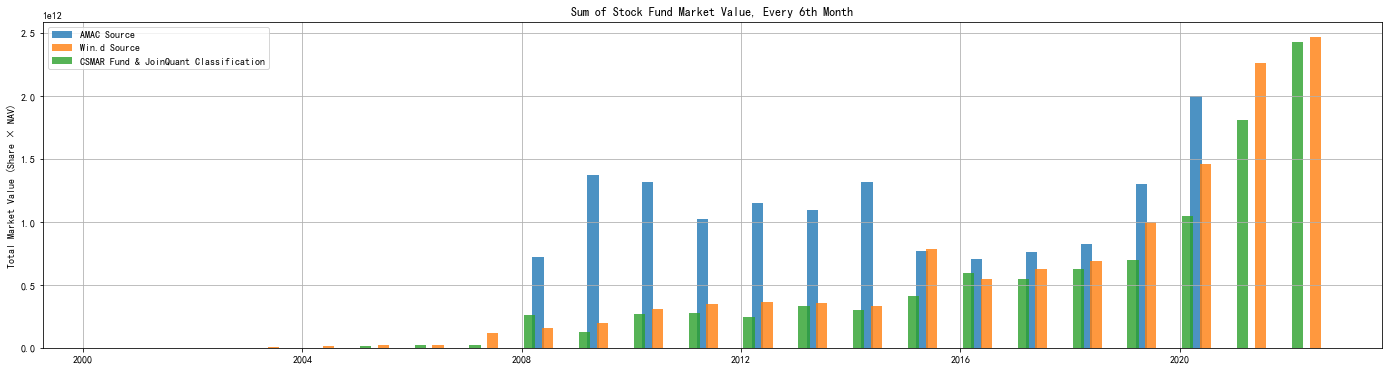

In [ ]:
plt.figure(figsize=(24, 6))
plt.bar(amac_full_market_value.股票基金.index - pd.Timedelta('10W'), amac_full_market_value.股票基金.values * 1e8, width=75, label='AMAC Source', alpha=.8)
plt.bar(wind_stock_fund_mkt_value.index - pd.Timedelta('1W'), wind_stock_fund_mkt_value.values, width=75, label='Win.d Source', alpha=.8)
plt.bar(csmar_stock_mkt_value_jq_classify.index + pd.Timedelta('8W'), csmar_stock_mkt_value_jq_classify.values, width=75, label='CSMAR Fund & JoinQuant Classification', alpha=.8)
plt.grid()
plt.ylabel('Total Market Value (Share × NAV)')
plt.title('Sum of Stock Fund Market Value, Every 6th Month')
plt.legend()
plt.show()

blend funds market value

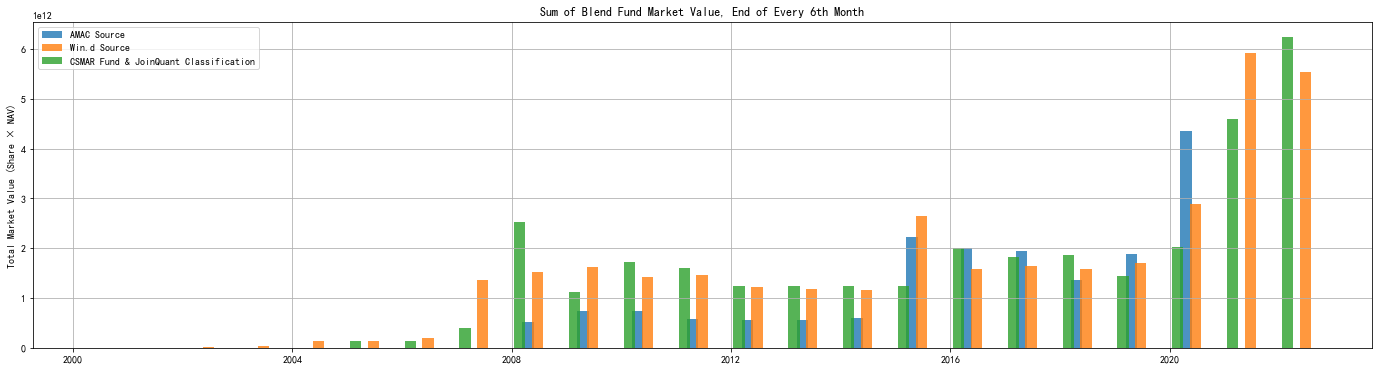

In [ ]:
plt.figure(figsize=(24, 6))
plt.bar(amac_full_market_value.混合基金.index - pd.Timedelta('10W'), amac_full_market_value.混合基金.values * 1e8, width=75, label='AMAC Source', alpha=.8)
plt.bar(wind_blend_fund_mkt_value.index - pd.Timedelta('1W'), wind_blend_fund_mkt_value.values, width=75, label='Win.d Source', alpha=.8)
plt.bar(csmar_blend_mkt_value_jq_classify.index + pd.Timedelta('8W'), csmar_blend_mkt_value_jq_classify.values, width=75, label='CSMAR Fund & JoinQuant Classification', alpha=.8)
plt.grid()
plt.ylabel('Total Market Value (Share × NAV)')
plt.title('Sum of Blend Fund Market Value, End of Every 6th Month')
plt.legend()
plt.show()

(stock + blend) funds market value

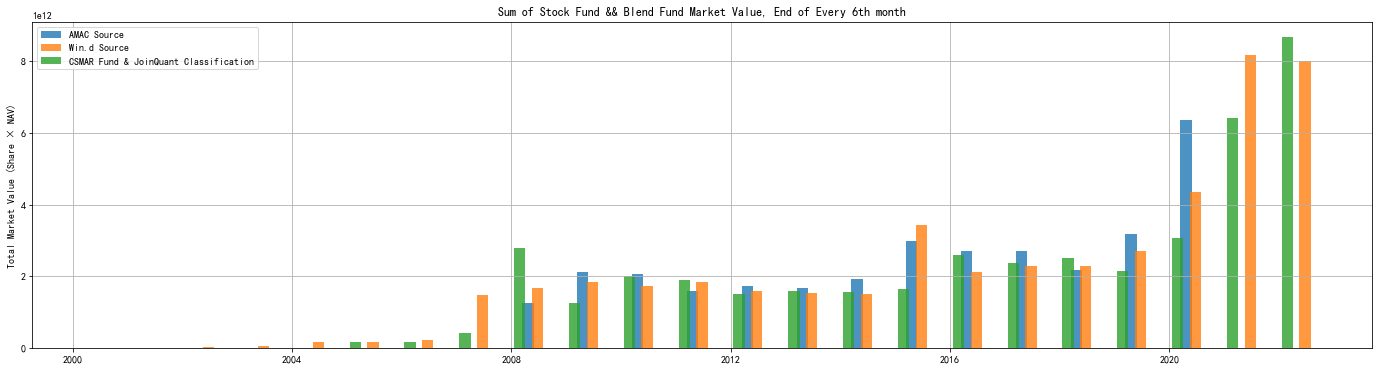

In [ ]:
plt.figure(figsize=(24, 6))
plt.bar(amac_full_market_value.混合基金.index - pd.Timedelta('10W'), (amac_full_market_value.混合基金.values + amac_full_market_value.股票基金.values) * 1e8, width=75, label='AMAC Source', alpha=.8)
plt.bar(wind_blend_fund_mkt_value.index - pd.Timedelta('1W'), \
     wind_blend_fund_mkt_value.values + wind_stock_fund_mkt_value.values, width=75, label='Win.d Source', alpha=.8)
plt.bar(csmar_blend_mkt_value_jq_classify.index + pd.Timedelta('8W'), \
     csmar_blend_mkt_value_jq_classify.values + csmar_stock_mkt_value_jq_classify.values, width=75, label='CSMAR Fund & JoinQuant Classification', alpha=.8)
plt.grid()
plt.ylabel('Total Market Value (Share × NAV)')
plt.title('Sum of Stock Fund && Blend Fund Market Value, End of Every 6th month')
plt.legend()
plt.show()

fund counts

In [ ]:
csmar_stock_fund_count = csmar_nav_monthly.loc[:, csmar_stock_code_6].apply(lambda x: pd.notna(x).sum(), axis=1)
csmar_stock_fund_count.index = csmar_stock_fund_count.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

csmar_blend_fund_count = csmar_nav_monthly.loc[:, csmar_blend_code_6].apply(lambda x: pd.notna(x).sum(), axis=1)
csmar_blend_fund_count.index = csmar_blend_fund_count.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

integrated plot

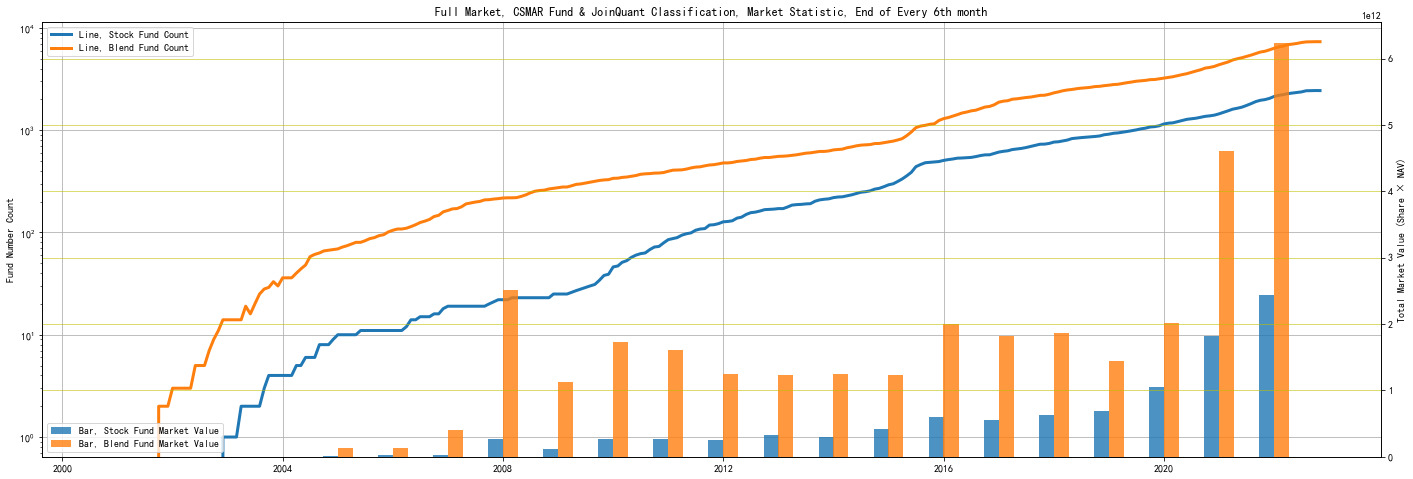

In [ ]:
fig, ax1 = plt.subplots()

fig.set_figheight(8)
fig.set_figwidth(24)

csmar_nav_monthly_6.loc[:, csmar_blend_code_6].apply(lambda x: pd.notna(x).sum(), axis=1)

csmar_stock_fund_count = csmar_nav_monthly.loc[:, csmar_stock_code_6].apply(lambda x: pd.notna(x).sum(), axis=1)
csmar_stock_fund_count.index = csmar_stock_fund_count.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

csmar_blend_fund_count = csmar_nav_monthly.loc[:, csmar_blend_code_6].apply(lambda x: pd.notna(x).sum(), axis=1)
csmar_blend_fund_count.index = csmar_blend_fund_count.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)


ax1.plot(csmar_stock_fund_count, linewidth=3, label='Line, Stock Fund Count')
ax1.plot(csmar_blend_fund_count, linewidth=3, label='Line, Blend Fund Count')

ax1.set_yscale('log')
ax1.set_yticks([1e0, 1e1, 1e2, 1e3, 1e4])
ax1.grid()
ax1.set_ylabel('Fund Number Count')

ax2 = ax1.twinx()

plt.bar(csmar_stock_mkt_value_jq_classify.index - pd.Timedelta('7W'), \
     csmar_stock_mkt_value_jq_classify.values, width=100, label='Bar, Stock Fund Market Value', alpha=.8)

plt.bar(csmar_blend_mkt_value_jq_classify.index + pd.Timedelta('7W'), \
     csmar_blend_mkt_value_jq_classify.values, width=100, label='Bar, Blend Fund Market Value', alpha=.8)

plt.title('Full Market, CSMAR Fund & JoinQuant Classification, Market Statistic, End of Every 6th month')

ax2.grid(color='y', alpha=.7)
plt.ylabel('Total Market Value (Share × NAV)')

ax1.legend(loc='upper left')
ax2.legend(loc='lower left')
plt.show()


## **III. Filters**

In [ ]:
from functools import reduce
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from data.CSMAR.daily_nav import csmar_nav_daily
from data.CSMAR.Fund_Allocation import csmar_fund_allocation
from data.CSMAR.FUND_FundCodeInfo import csmar_symbol_code_mapping
from data.CSMAR.Fund_FundDividend import csmar_fund_dividend
from data.CSMAR.Fund_Resolution import csmar_fund_resolution
from data.JoinQuant.jq_all_fund_main_info import jq_all_fund_main_info
from data.TwoStepData.csmar_nav_monthly import csmar_nav_monthly

### preview

In [ ]:
csmar_jq_co_fund = np.intersect1d(np.char.zfill(csmar_nav_daily.Symbol.unique().astype(str), 6), jq_all_fund_main_info.main_code)
csmar_jq_co_fund = pd.Series(csmar_jq_co_fund, name='main_code')

final_main_info = pd.merge(jq_all_fund_main_info, csmar_jq_co_fund, on='main_code')[['main_code', 'operate_mode', 'underlying_asset_type', 'start_date']]


In [ ]:
specs = [[{'type':'domain'}] * 2]
fig = make_subplots(rows=1, cols=2, specs=specs, subplot_titles=['JoinQuant Asset Type', 'JoinQuant Operation Mode'])
fig.add_trace(go.Pie(labels=final_main_info.underlying_asset_type.value_counts().index, values=final_main_info.underlying_asset_type.value_counts().values), 1, 1)
fig.add_trace(go.Pie(labels=final_main_info.operate_mode.value_counts().index, values=final_main_info.operate_mode.value_counts().values), 1, 2)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update(layout_showlegend=False)
fig.update_layout(width=1200, height=500)

### 1. static filtering

（1）基金类别为“股票型基金”或“混合型基金”；


（2）基金非 ETF 类基金、非 QDII 类基金

<!-- （4）主动管理标识为 1 或者为空； -->

In [ ]:
final_main_info

,main_code,operate_mode,underlying_asset_type,start_date
0,000001,开放式基金,混合型,2001-12
1,000003,开放式基金,债券型,2013-03
2,000004,开放式基金,债券型,2013-03
3,000005,开放式基金,债券型,2013-03
4,000006,开放式基金,混合型,2019-03
...,...,...,...,...
16498,968083,开放式基金,债券型,2020-04
16499,968084,开放式基金,债券型,2020-04
16500,968085,开放式基金,债券型,2020-04
16501,968086,开放式基金,债券型,2020-04


In [ ]:
filter_1 = np.logical_or(final_main_info.underlying_asset_type == '股票型', final_main_info.underlying_asset_type == '混合型')
filter_2 = final_main_info.operate_mode == '开放式基金'


filters = [(1, filter_1), (2, filter_2)]
np.array(list(map(lambda _: _[1].sum(), filters))) / len(final_main_info)

# proportional data left

array([0.61909956, 0.76125553])

In [ ]:

def func(previous, now):
    if type(previous) == tuple:
        print(f'filter {previous[0]}: {len(final_main_info)} to {previous[1].sum()}')
        temp = np.logical_and(previous[1], now[1])
        print(f'filter {now[0]}: {previous[1].sum()} to {temp.sum()}')
        return temp
    else:
        temp = np.logical_and(previous, now[1])
        print(f'filter {now[0]}: {previous.sum()} to {temp.sum()}')
        return temp


filters_ = reduce(func, filters)

filter 1: 16503 to 10217
filter 2: 10217 to 7327


In [ ]:
final_main_info = final_main_info[filters_]
final_main_info.set_index('main_code').sort_index()

,operate_mode,underlying_asset_type,start_date
main_code,,,
000001,开放式基金,混合型,2001-12
000006,开放式基金,混合型,2019-03
000011,开放式基金,混合型,2004-08
000017,开放式基金,混合型,2013-03
000020,开放式基金,混合型,2013-03
...,...,...,...
968045,开放式基金,股票型,2019-03
968046,开放式基金,股票型,2019-03
968047,开放式基金,股票型,2019-03


### 2. big table

from `code` indexed only to `code-month` multiIndex

In [ ]:
indexes = pd.MultiIndex.from_product([final_main_info.main_code.sort_values().values, pd.date_range('2000-1', (datetime.datetime.now() + pd.offsets.MonthEnd(1)).strftime('%Y-%m'), freq='M')])
temp_codes = indexes.get_level_values(0)
temp_date = indexes.get_level_values(1)
main_data = pd.DataFrame(index=indexes)
main_data['main_code'] = temp_codes
main_data['Date'] = temp_date.to_period('M')
main_data = pd.merge(main_data, final_main_info, on='main_code')
main_data = main_data.rename(columns={'main_code': 'Symbol'})
main_data = main_data.set_index(['Symbol', 'Date'])
main_data = main_data.loc[csmar_nav_monthly[final_main_info.main_code.sort_values().values].stack().index.swaplevel()].sort_index()
main_data

operate_mode underlying_asset_type start_date
Symbol Date                                                 
000001 2001-12        开放式基金                   混合型    2001-12
       2002-01        开放式基金                   混合型    2001-12
       2002-02        开放式基金                   混合型    2001-12
       2002-03        开放式基金                   混合型    2001-12
       2002-04        开放式基金                   混合型    2001-12
...                     ...                   ...        ...
968049 2022-06        开放式基金                   股票型    2019-03
       2022-07        开放式基金                   股票型    2019-03
       2022-08        开放式基金                   股票型    2019-03
       2022-09        开放式基金                   股票型    2019-03
       2022-10        开放式基金                   股票型    2019-03

[364816 rows x 3 columns]

### 3. dynamic filtering

（3）基金上市时间超过一年

（4）最近一次**二季度报/年报/半年报**~~年报或半年报~~披露的中国市场股票持股比例超过总管理规模的30%

In [ ]:
main_data = main_data[main_data.index.get_level_values(1) >= main_data.start_date + pd.offsets.MonthEnd(12)]
record_shape = len(main_data.index.get_level_values(0).unique())
f'in view of 2022, filter 3: {len(final_main_info)} to {record_shape}'

'in view of 2022, filter 3: 7327 to 5916'

*problem*: annual report or semi-annual report not available before 2008

*reason*: regulation rule changed

*solve*: add second quarter report

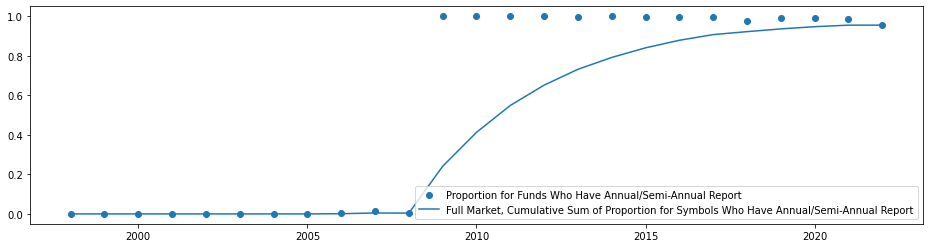

In [ ]:
csmar_fund_allocation['report_type_check'] = csmar_fund_allocation.Date.dt.year
report_type_check = csmar_fund_allocation.groupby(['MasterFundCode', 'report_type_check']).apply(lambda temp : 5 in temp.ReportTypeID.values or 6 in temp.ReportTypeID.values)
plt.figure(figsize=(16,4))
report_type_check_ = report_type_check.groupby(level=1).apply(lambda temp: temp.sum() / len(temp))
year_report_count = report_type_check.groupby(level=1).apply(lambda temp: temp.sum())
total_report_count = report_type_check.groupby(level=1).apply(lambda temp: len(temp))
plt.scatter(x=report_type_check_.index, y=report_type_check_.values, label='Proportion for Funds Who Have Annual/Semi-Annual Report')
temp = year_report_count.cumsum() / total_report_count.cumsum()
plt.plot(temp.index, temp.values, label='Full Market, Cumulative Sum of Proportion for Symbols Who Have Annual/Semi-Annual Report')
plt.legend()
pass

<img src="image/README/2008_search.png" alt="drawing" width="500"/> <img src="image/README/2009_search.png" alt="drawing" width="508"/>

[中国证券监督管理委员会公告〔2008〕第4号](http://www.gov.cn/zwgk/2008-02/21/content_896020.htm)


使用存在二季度报/年报/半年报的数据

In [ ]:
csmar_fund_allocation = csmar_fund_allocation[csmar_fund_allocation.ReportTypeID.isin([2, 5, 6])]
csmar_fund_allocation = pd.merge(csmar_fund_allocation, csmar_symbol_code_mapping, on='MasterFundCode', how='left')
csmar_fund_allocation = csmar_fund_allocation[csmar_fund_allocation.Symbol.isin(main_data.index.get_level_values(0).unique())]
main_data = main_data.loc[csmar_fund_allocation.Symbol.unique(), slice(None)]

中国市场股票持股比例超过总管理规模30%

In [ ]:
filter_4 = csmar_fund_allocation[(csmar_fund_allocation.Equity / csmar_fund_allocation.TotalAsset) > .3]
co_index = np.intersect1d(filter_4.set_index(['Symbol', 'Date']).index, main_data.index)
main_data['filter_4'] = np.nan
main_data.loc[main_data.index.get_level_values(1).month == 6, 'filter_4'] = False
main_data.loc[co_index, 'filter_4'] = True
main_data = main_data.groupby(level=0).fillna(method='ffill').fillna(False)
main_data = main_data[main_data.filter_4].drop('filter_4', axis=1)
main_data

operate_mode underlying_asset_type start_date
Symbol Date                                                 
000001 2003-06        开放式基金                   混合型    2001-12
       2003-07        开放式基金                   混合型    2001-12
       2003-08        开放式基金                   混合型    2001-12
       2003-09        开放式基金                   混合型    2001-12
       2003-10        开放式基金                   混合型    2001-12
...                     ...                   ...        ...
910028 2022-06        开放式基金                   混合型    2021-06
       2022-07        开放式基金                   混合型    2021-06
       2022-08        开放式基金                   混合型    2021-06
       2022-09        开放式基金                   混合型    2021-06
       2022-10        开放式基金                   混合型    2021-06

[215282 rows x 3 columns]

In [ ]:
f'in view of all time span, filter 4: {record_shape} to {len(main_data.index.get_level_values(0).unique())}'

'in view of all time span, filter 4: 5916 to 4624'

### 4. full data

reset nav

In [ ]:
csmar_nav_monthly = pd.Series(csmar_nav_monthly.stack().swaplevel(), name='NAV')
csmar_nav_monthly = pd.DataFrame(csmar_nav_monthly).reset_index()

merge data

In [ ]:
main_data = pd.merge(main_data, csmar_nav_monthly, on=['Symbol', 'Date'], how='left').set_index(['Symbol', 'Date'])
main_data = pd.merge(main_data, csmar_fund_dividend, on=['Symbol', 'Date'], how='left').set_index(['Symbol', 'Date'])
main_data = pd.merge(main_data, csmar_fund_resolution, on=['Symbol', 'Date'], how='left').set_index(['Symbol', 'Date'])

handle NA

In [ ]:
main_data['NAV'] = main_data.groupby(level=0).apply(lambda x: x.NAV.fillna(method='ffill')).droplevel(0)
main_data['DividendperShare'] = main_data.DividendperShare.fillna(0)
main_data['SplitRatio'] = main_data.SplitRatio.fillna(1)

## **IV. Overall Performance**

### Return

$$
R_t^{real}=\frac{\left(NAV_t+Div_t\right)*SF_t}{NAV_{t-1}*SF_{t-1}}\tag{1}
$$

$NAV_t$ 基金在 $t$ 月末的基金净值

$Div_t$ 在 $t$ 月中发放的现金分红

$SF_t$ 累计拆分因子

当$t$月中发生比例为$s_t$的拆分时, $SF_t=s_tSF_{t-1}$

公式等价于

$$
R_t^{real}=\frac{\left(NAV_t+Div_t\right)*s_t}{NAV_{t-1}}\tag{2}
$$

#### 1. prepare

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

from data.CSMAR.Fund_ShareChange import csmar_share_info
from data.JoinQuant.jq_all_fund_main_info import jq_all_fund_main_info
from data.SVC.svc_source import svc_source
from data.TwoStepData.csmar_nav_monthly import csmar_nav_monthly
from data.TwoStepData.main_data import main_data
from utils.functions import *

In [ ]:
main_data

operate_mode underlying_asset_type start_date     NAV  \
Symbol Date                                                            
000001 2003-06        开放式基金                   混合型    2001-12  0.9730   
       2003-07        开放式基金                   混合型    2001-12  0.9860   
       2003-08        开放式基金                   混合型    2001-12  0.9540   
       2003-09        开放式基金                   混合型    2001-12  0.9200   
       2003-10        开放式基金                   混合型    2001-12  0.9360   
...                     ...                   ...        ...     ...   
952009 2022-06        封闭式基金                   混合型    2020-01  1.8868   
       2022-07        封闭式基金                   混合型    2020-01  1.7885   
       2022-08        封闭式基金                   混合型    2020-01  1.7257   
       2022-09        封闭式基金                   混合型    2020-01  1.6665   
       2022-10        封闭式基金                   混合型    2020-01  1.5892   

                DividendperShare  SplitRatio  NAV_shift  adj_factor  adj_NAV  
Symbol Date                                                                   
000001 2003-06             0.033         1.0        NaN         NaN      NaN  
       2003-07             0.000         1.0     0.9730         1.0   0.9860  
       2003-08             0.000         1.0     0.9860         1.0   0.9540  
       2003-09             0.000         1.0     0.9540         1.0   0.9200  
       2003-10             0.000         1.0     0.9200         1.0   0.9360  
...                          ...         ...        ...         ...      ...  
952009 2022-06             0.000         1.0     1.7120         1.0   1.8868  
       2022-07             0.000         1.0     1.8868         1.0   1.7885  
       2022-08             0.000         1.0     1.7885         1.0   1.7257  
       2022-09             0.000         1.0     1.7257         1.0   1.6665  
       2022-10             0.000         1.0     1.6665         1.0   1.5892  

[240697 rows x 9 columns]

NAV_shift calculation

In [ ]:
main_data['NAV_shift'] = main_data.groupby(level=0).apply(lambda x: x.NAV.shift(1)).droplevel(0)

split into stock fund and blend fund

apply formula

In [ ]:
blend_data = main_data[main_data.underlying_asset_type == '混合型']
stock_data = main_data[main_data.underlying_asset_type == '股票型']


return_of_csmar_stock_fund = stock_data.groupby(level=0).apply(lambda x: ((x.NAV + x.DividendperShare) * x.SplitRatio) / x.NAV_shift).droplevel(0)
return_of_csmar_blend_fund = blend_data.groupby(level=0).apply(lambda x: ((x.NAV + x.DividendperShare) * x.SplitRatio) / x.NAV_shift).droplevel(0)
return_of_all_fund = main_data.groupby(level=0).apply(lambda x: ((x.NAV + x.DividendperShare) * x.SplitRatio) / x.NAV_shift).droplevel(0)


market value weight generation

In [ ]:
MONTH_OF_YEAR = 6

csmar_share_info = csmar_share_info.drop_duplicates(subset=['Symbol', 'Date']).pivot(index='Date', columns='Symbol', values='EndDateShares')

csmar_share_info_yearly = csmar_share_info[csmar_share_info.index.month == MONTH_OF_YEAR]
csmar_nav_yearly = csmar_nav_monthly[csmar_nav_monthly.index.month == MONTH_OF_YEAR]

csmar_co_time_6 = np.intersect1d(csmar_share_info_yearly.index, csmar_nav_yearly.index)

csmar_blend_code_6 = np.intersect1d(csmar_nav_yearly.columns, jq_all_fund_main_info[jq_all_fund_main_info.underlying_asset_type == '混合型'].main_code.values)
csmar_blend_code_6 = np.intersect1d(csmar_blend_code_6, csmar_share_info_yearly.columns)

csmar_stock_code_6 = np.intersect1d(csmar_nav_yearly.columns, jq_all_fund_main_info[jq_all_fund_main_info.underlying_asset_type == '股票型'].main_code.values)
csmar_stock_code_6 = np.intersect1d(csmar_stock_code_6, csmar_share_info_yearly.columns)



csmar_stock_fund_weight_yearly = (csmar_share_info_yearly.loc[csmar_co_time_6, csmar_stock_code_6] * csmar_nav_yearly.loc[csmar_co_time_6, csmar_stock_code_6])

csmar_stock_fund_weight_yearly = pd.concat([csmar_stock_fund_weight_yearly, \
    pd.DataFrame([[np.nan] * csmar_stock_fund_weight_yearly.shape[1]], index=[pd.to_datetime('2023-06').to_period('M')], columns=csmar_stock_fund_weight_yearly.columns)])

csmar_stock_fund_weight_yearly = csmar_stock_fund_weight_yearly.resample('M').ffill()

stock_fund_dates = return_of_csmar_stock_fund.unstack(level=0).index
stock_fund_funds = return_of_csmar_stock_fund.unstack(level=0).columns

stock_fund_new = np.setdiff1d(stock_fund_funds, csmar_stock_fund_weight_yearly.columns)
print(f'{stock_fund_new} will not be used')

stock_fund_funds = np.intersect1d(stock_fund_funds, csmar_stock_fund_weight_yearly.columns)

csmar_stock_fund_weight_yearly = csmar_stock_fund_weight_yearly.loc[stock_fund_dates, stock_fund_funds]
csmar_stock_fund_weight_yearly = csmar_stock_fund_weight_yearly.div(csmar_stock_fund_weight_yearly.sum(axis=1), axis=0)

['007593' '007594'] will not be used


In [ ]:

csmar_blend_fund_weight_yearly = (csmar_share_info_yearly.loc[csmar_co_time_6, csmar_blend_code_6] * csmar_nav_yearly.loc[csmar_co_time_6, csmar_blend_code_6])
csmar_blend_fund_weight_yearly = pd.concat([csmar_blend_fund_weight_yearly, \
    pd.DataFrame([[np.nan] * csmar_blend_fund_weight_yearly.shape[1]], index=[pd.to_datetime('2023-06').to_period('M')], columns=csmar_blend_fund_weight_yearly.columns)])
csmar_blend_fund_weight_yearly = csmar_blend_fund_weight_yearly.resample('M').ffill()

blend_fund_dates = return_of_csmar_blend_fund.unstack(level=0).index
blend_fund_funds = return_of_csmar_blend_fund.unstack(level=0).columns

blend_fund_new = np.setdiff1d(blend_fund_funds, csmar_blend_fund_weight_yearly.columns)
print(f'{blend_fund_new} will not be used')
blend_fund_funds = np.intersect1d(blend_fund_funds, csmar_blend_fund_weight_yearly.columns)

csmar_blend_fund_weight_yearly = csmar_blend_fund_weight_yearly.loc[blend_fund_dates, blend_fund_funds]
csmar_blend_fund_weight_yearly = csmar_blend_fund_weight_yearly.div(csmar_blend_fund_weight_yearly.sum(axis=1), axis=0)


['004112' '004212' '004783' '005392' '009911' '010398' '010399' '519610'
 '519611' '519612' '960002' '960004'] will not be used


#### 2. analysis

use data later than 2005-06

In [ ]:
return_of_csmar_stock_fund.unstack(level=0)

Symbol,000042,000059,000082,000176,000309,000311,000312,000313,000326,000368,...,660011,671030,673090,673100,673101,690008,700002,740101,960000,960022
Date,,,,,,,,,,,,,,,,,,,,,
2004-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06,1.083720,1.093872,1.097926,1.108846,1.162114,1.099558,1.119288,1.118925,1.121493,1.075491,...,1.073979,1.186415,1.074244,1.107217,1.106920,1.073746,1.108399,1.108128,1.077097,NaN
2022-07,0.948945,0.927085,0.957503,0.934405,1.009198,0.938431,0.939431,0.939095,0.964950,0.943766,...,0.979501,0.951419,0.950455,0.940773,0.940471,0.967033,0.946249,0.946837,0.934307,NaN
2022-08,0.982664,0.982851,0.981370,0.989452,0.927342,0.993568,0.983288,0.982950,0.977824,0.994084,...,0.980644,0.978594,0.958385,0.982208,0.981824,0.989583,0.967653,0.972281,0.978288,NaN


Text(0.5, 1.0, 'Across Funds, Mean of Rolling 12 Months Volatility')

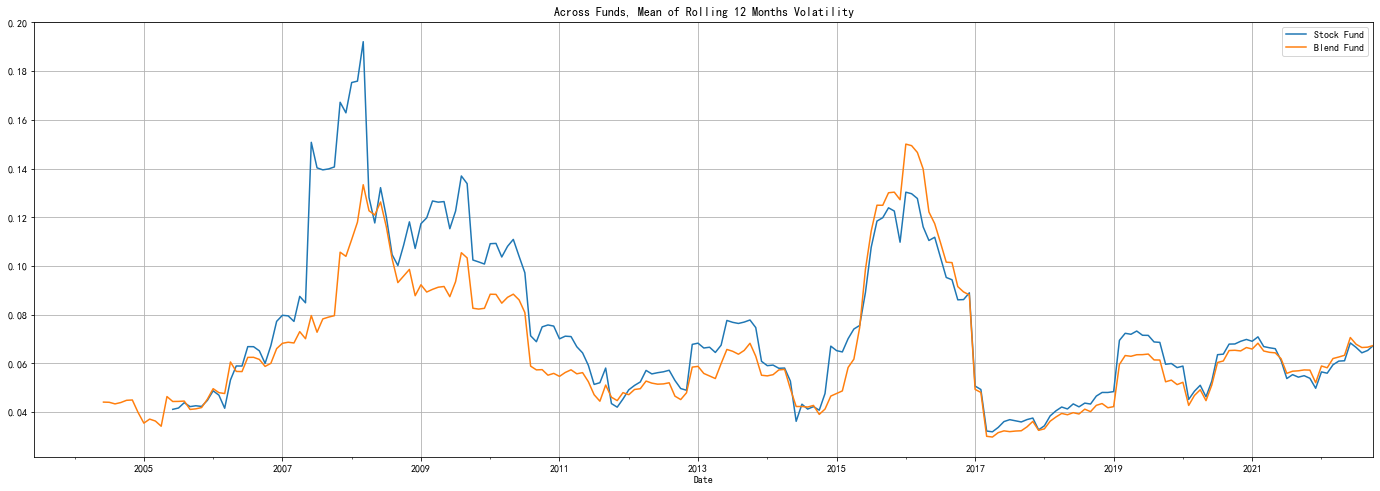

In [ ]:
plt.figure(figsize=(24, 8))
rolling_months = 12
(return_of_csmar_stock_fund.unstack(level=0) - 1).rolling(rolling_months).std().mean(axis=1).plot(label='Stock Fund')
(return_of_csmar_blend_fund.unstack(level=0) - 1).rolling(rolling_months).std().mean(axis=1).plot(label='Blend Fund')
plt.grid()
plt.legend()
plt.title(f'Across Funds, Mean of Rolling {rolling_months} Months Volatility')

<AxesSubplot:>

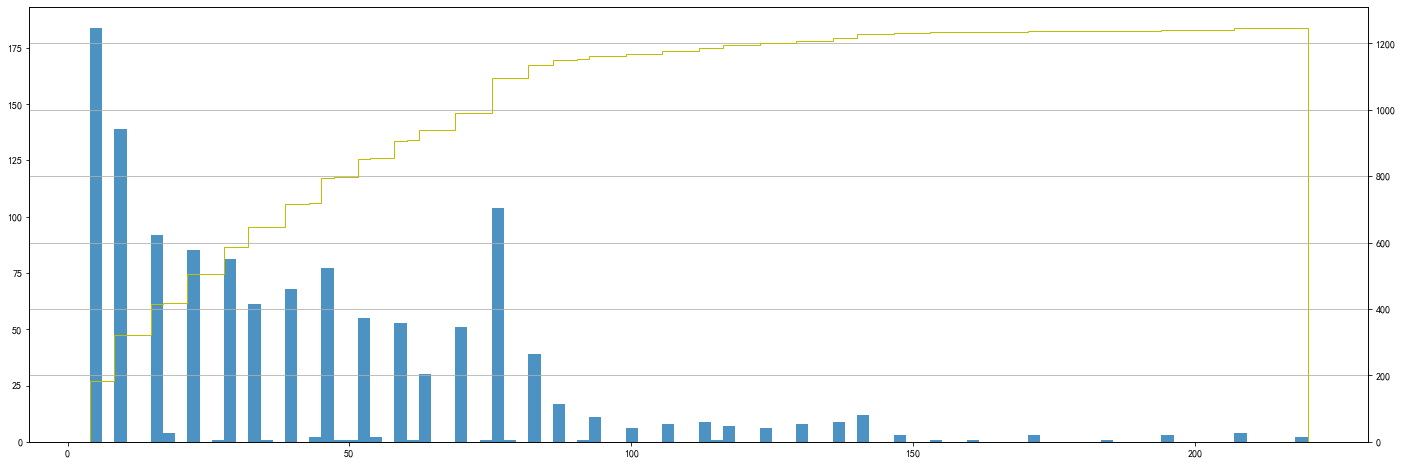

In [ ]:
fig, ax = plt.subplots(figsize=(24, 8))
return_of_csmar_stock_fund.unstack(level=0).describe().loc['count'].hist(bins=100, ax=ax, alpha=.8)
ax.grid(False)
ax1 = ax.twinx()
return_of_csmar_stock_fund.unstack(level=0).describe().loc['count'].hist(bins=100, cumulative=True, histtype='step', ax=ax1, color='y')

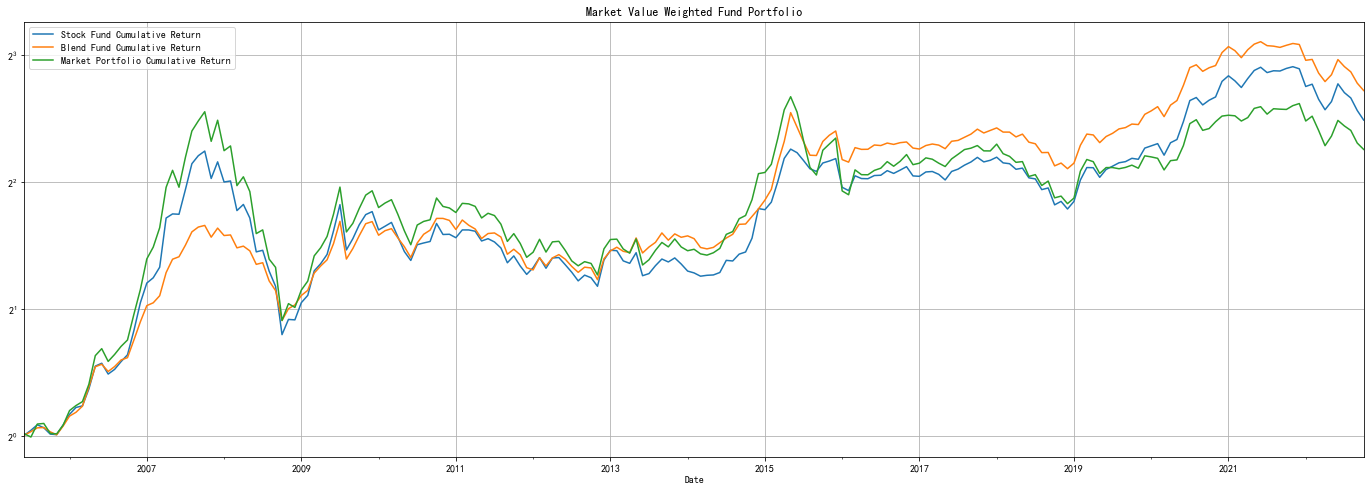

In [ ]:
plt.figure(figsize=(24,8))

(((return_of_csmar_stock_fund.unstack(level=0) - 1) * csmar_stock_fund_weight_yearly).sum(axis=1) + 1).loc['2005-6':].cumprod().plot(label='Stock Fund Cumulative Return')
(((return_of_csmar_blend_fund.unstack(level=0) - 1) * csmar_blend_fund_weight_yearly).sum(axis=1) + 1).loc['2005-6':].cumprod().plot(label='Blend Fund Cumulative Return')
((svc_source.loc['2005-6': ].mktrf + svc_source.loc['2005-6': ].rf) + 1).cumprod().plot(label='Market Portfolio Cumulative Return')

plt.yscale('log', base=2)
plt.title('Market Value Weighted Fund Portfolio')
plt.grid()
plt.legend()
plt.show()


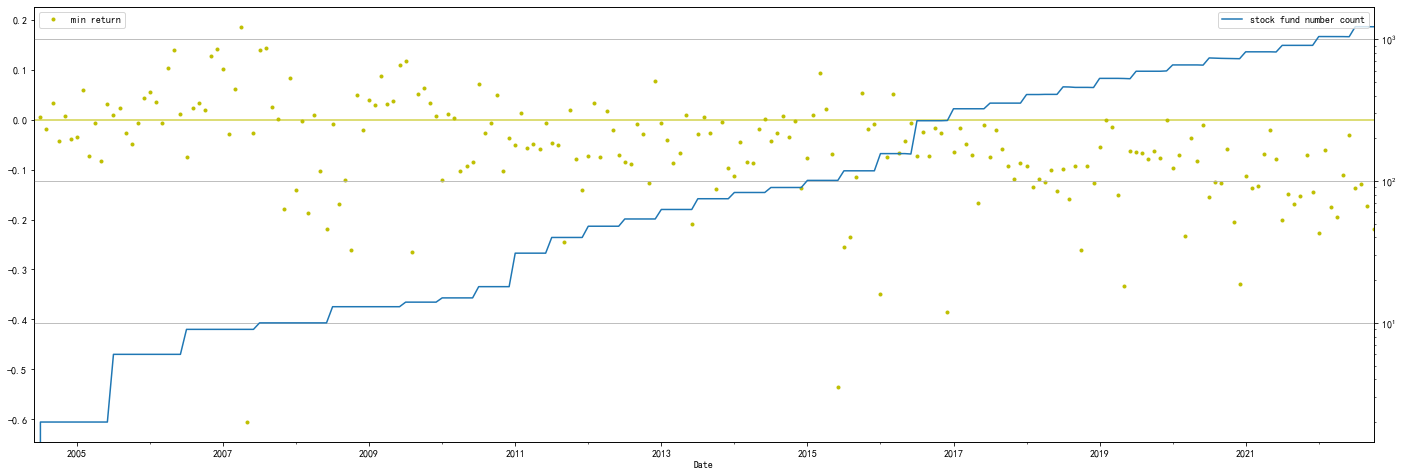

In [ ]:
fig, ax1 = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(24)
(return_of_csmar_stock_fund.unstack(0) - 1).T.describe().loc['min'].plot(ax=ax1, style='.', label='min return', color='y')
ax1.legend()
ax1.legend(loc='upper left')
ax1.axhline(color='y', alpha=.7)
ax2 = ax1.twinx()
(return_of_csmar_stock_fund.unstack(0) - 1).T.describe().loc['count'].plot(ax=ax2, label='stock fund number count')
ax2.grid()
ax2.set_yscale('log')
ax2.legend(loc='upper right')

In [ ]:
# plt.figure(figsize=(24,8))
# return_of_stock_fund.groupby(level=1).mean().loc['2005-6':].cumprod().plot(label='Stock Fund Cumulative Return')
# return_of_blend_fund.groupby(level=1).mean().loc['2005-6':].cumprod().plot(label='Blend Fund Cumulative Return')
# plt.yscale('log', base=2)
# plt.title('1/N Weighted Fund Portfolio')
# plt.grid()
# plt.legend()

why use data later than 2005-06?

In [ ]:
co_time = np.intersect1d(csmar_share_info.index, csmar_nav_monthly.index)
co_stocks = np.intersect1d(csmar_share_info.columns, csmar_nav_monthly.columns)
compare_share_info = csmar_share_info.loc[co_time, co_stocks]
compare_nav_monthly = csmar_nav_monthly.loc[co_time, co_stocks]

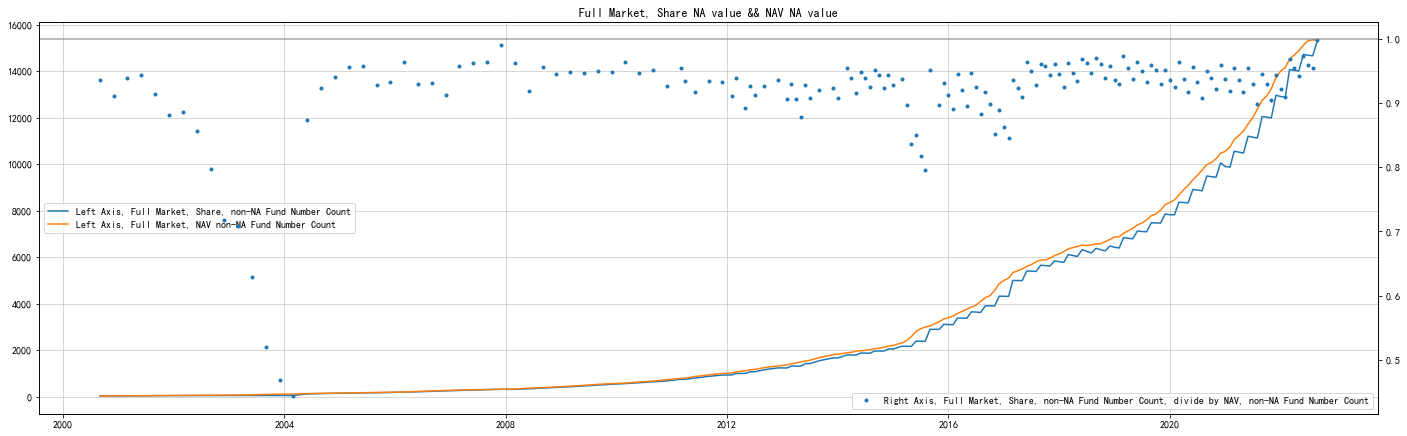

In [ ]:
filled_share_info = compare_share_info.fillna(method='ffill')
fig, ax1 = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(24)
def na_compare(row):
    date = row.name
    available_funds = row.dropna().index
    selected_share_info = (row * filled_share_info.loc[date]).dropna()
    available_share_funds = selected_share_info.index

    return [len(available_share_funds), len(available_funds)]

temp = np.array(list(compare_nav_monthly.apply(na_compare, axis=1).values))
ax1.plot(compare_nav_monthly.index.astype(np.datetime64), temp[:, 0], label='Left Axis, Full Market, Share, non-NA Fund Number Count')
ax1.plot(compare_nav_monthly.index.astype(np.datetime64), temp[:, 1], label='Left Axis, Full Market, NAV non-NA Fund Number Count')
ax1.legend(loc='center left')
ax1.grid(linewidth=.5)

ax2 = ax1.twinx()

pd.Series(temp[:, 0] / temp[:, 1] ,index=compare_nav_monthly.index.astype(np.datetime64)).plot(style='.', label='Right Axis, Full Market, Share, non-NA Fund Number Count, divide by NAV, non-NA Fund Number Count')
plt.title('Full Market, Share NA value && NAV NA value')
ax2.legend(loc='lower right')

ax2.axhline(y=1, color='grey', alpha=.7)


Size effect in fund?

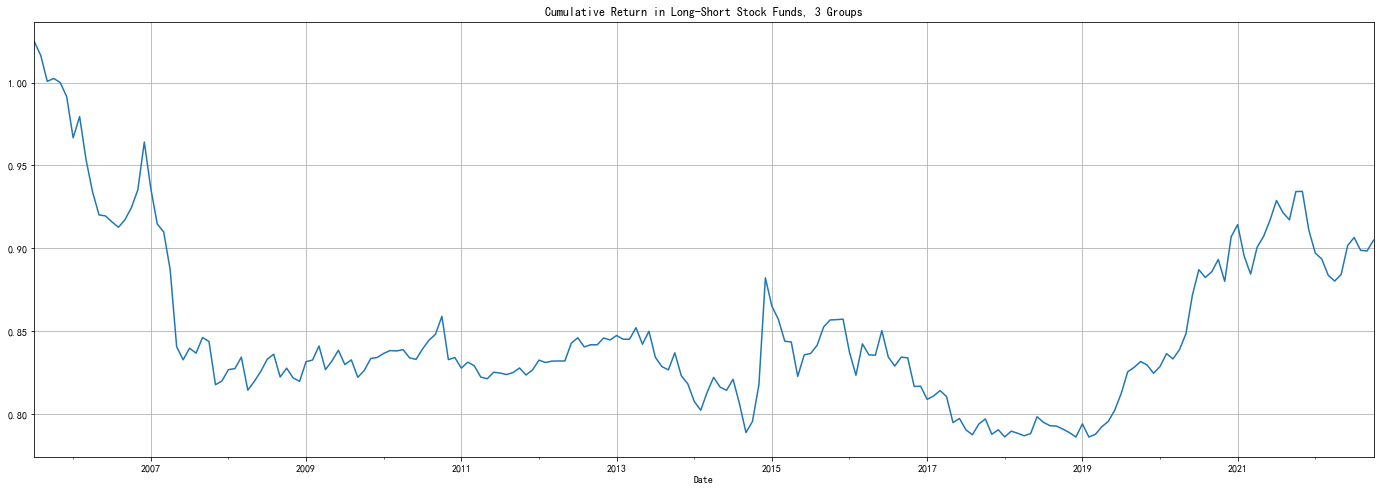

In [ ]:
stock_fund_weight_ = (csmar_share_info_yearly.loc[csmar_co_time_6, csmar_stock_code_6] * csmar_nav_yearly.loc[csmar_co_time_6, csmar_stock_code_6])
stock_fund_weight_ = pd.concat([stock_fund_weight_, \
    pd.DataFrame([[np.nan] * stock_fund_weight_.shape[1]], index=[pd.to_datetime('2023-06').to_period('M')], columns=stock_fund_weight_.columns)])
stock_fund_weight_ = stock_fund_weight_.resample('M').ffill()

groups = 3
ret_stock_fund = return_of_csmar_stock_fund.unstack(0) - 1
stock_fund_groups = stock_fund_weight_.dropna(how='all').apply(lambda x: pd.qcut(x, groups, labels=np.arange(groups)) if not pd.isna(x).all() else x, axis=1)
co_time = np.intersect1d(stock_fund_groups.index, ret_stock_fund.index)
co_stocks = np.intersect1d(stock_fund_groups.columns, ret_stock_fund.columns)

stock_fund_groups = stock_fund_groups.loc[co_time, co_stocks]
ret_stock_fund = ret_stock_fund.loc[co_time, co_stocks]

def func(x):
    date = x.name
    result = pd.DataFrame([x, stock_fund_groups.loc[date]], index=['return', 'rank']).T.groupby('rank').mean().iloc[:, 0]
    if result.shape[0] < groups:
        
        return pd.Series([np.nan] * groups, name=date)
    else:
        return result

stock_grouped_return = ret_stock_fund.apply(func, axis=1).dropna()
plt.figure(figsize=(24, 8))
plt.title(f'Cumulative Return in Long-Short Stock Funds, {groups} Groups')
(stock_grouped_return.iloc[:, -1] - stock_grouped_return.iloc[:, 0] + 1).cumprod().plot()
plt.grid()

In [ ]:
stats.ttest_1samp((stock_grouped_return.iloc[:, -1] - stock_grouped_return.iloc[:, 0]).dropna(), 0, alternative ='greater')

Ttest_1sampResult(statistic=-0.4280697831117795, pvalue=0.6654773213617575)

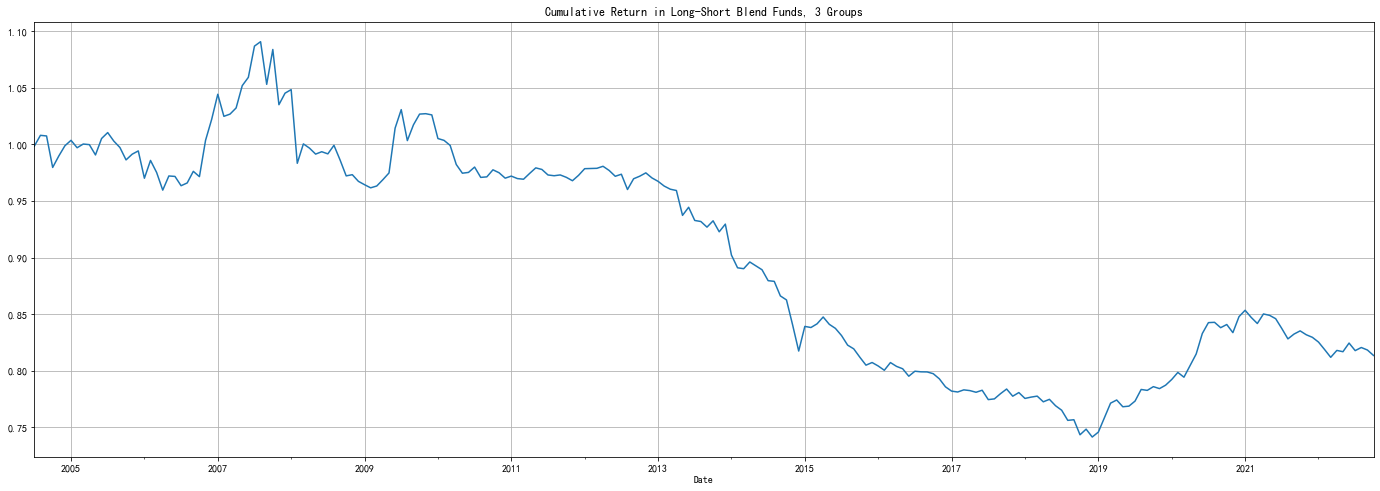

In [ ]:
blend_fund_weight_ = (csmar_share_info_yearly.loc[csmar_co_time_6, csmar_blend_code_6] * csmar_nav_yearly.loc[csmar_co_time_6, csmar_blend_code_6])
blend_fund_weight_ = pd.concat([blend_fund_weight_, \
    pd.DataFrame([[np.nan] * blend_fund_weight_.shape[1]], index=[pd.to_datetime('2023-06').to_period('M')], columns=blend_fund_weight_.columns)])
blend_fund_weight_ = blend_fund_weight_.resample('M').ffill()

groups = 3
ret_blend_fund = return_of_csmar_blend_fund.unstack(0) - 1
blend_fund_groups = blend_fund_weight_.dropna(how='all').apply(lambda x: pd.qcut(x, groups, labels=np.arange(groups)) if not pd.isna(x).all() else x, axis=1)
co_time = np.intersect1d(blend_fund_groups.index, ret_blend_fund.index)
co_stocks = np.intersect1d(blend_fund_groups.columns, ret_blend_fund.columns)

blend_fund_groups = blend_fund_groups.loc[co_time, co_stocks]
ret_blend_fund = ret_blend_fund.loc[co_time, co_stocks]

def func(x):
    date = x.name
    result = pd.DataFrame([x, blend_fund_groups.loc[date]], index=['return', 'rank']).T.groupby('rank').mean().iloc[:, 0]
    if result.shape[0] < groups:
        
        return pd.Series([np.nan] * groups, name=date)
    else:
        return result
plt.figure(figsize=(24, 8))
plt.title(f'Cumulative Return in Long-Short Blend Funds, {groups} Groups')
blend_grouped_return = ret_blend_fund.apply(func, axis=1).dropna()

(blend_grouped_return.iloc[:, -1] - blend_grouped_return.iloc[:, 0] + 1).cumprod().plot()
plt.grid()

In [ ]:
stats.ttest_1samp((blend_grouped_return.iloc[:, -1] - blend_grouped_return.iloc[:, 0]).dropna(), 0, alternative ='greater')

Ttest_1sampResult(statistic=-1.1071280457833819, pvalue=0.8652734362722437)

### Regression

In [ ]:
import pandas as pd
import statsmodels.api as sm
from utils.functions import *

from data.SVC.svc_source import svc_source
from data.TwoStepData.csmar_blend_fund_weight_yearly import csmar_blend_fund_weight_yearly
from data.TwoStepData.csmar_stock_fund_weight_yearly import csmar_stock_fund_weight_yearly
from data.TwoStepData.return_of_csmar_blend_fund import return_of_csmar_blend_fund
from data.TwoStepData.return_of_csmar_stock_fund import return_of_csmar_stock_fund

regression table construction

In [ ]:
stock_fund_regression = (return_of_csmar_stock_fund.unstack(level=0) * csmar_stock_fund_weight_yearly).sum(axis=1).sort_index()
stock_fund_regression.name = 'stock_fund'

blend_fund_regression = (return_of_csmar_blend_fund.unstack(level=0) * csmar_blend_fund_weight_yearly).sum(axis=1).sort_index()
blend_fund_regression.name = 'blend_fund'


regression_source = pd.merge(stock_fund_regression, svc_source[['mktrf', 'rf', 'smb', 'vmg']], on='Date')
regression_source = pd.merge(regression_source, blend_fund_regression, on='Date')

regression_source['α'] = 1

regression_source = regression_source.loc['2005-6':]
regression_source

,stock_fund,mktrf,rf,smb,vmg,blend_fund,α
Date,,,,,,,
2005-06,0.006722,0.011522,0.001856,0.000517,0.056121,0.006373,1
2005-07,0.004098,-0.019041,0.001856,-0.051082,0.071114,0.004433,1
2005-08,0.030586,0.071589,0.001856,0.094712,-0.049516,0.021039,1
2005-09,-0.016050,0.001288,0.001856,0.033242,0.045120,0.001628,1
2005-10,-0.034043,-0.054595,0.001856,-0.001480,0.024557,-0.023213,1
...,...,...,...,...,...,...,...
2022-06,0.101756,0.088114,0.001241,-0.020506,-0.028009,0.086277,1
2022-07,-0.042236,-0.030989,0.001241,0.071198,-0.005291,-0.031624,1
2022-08,-0.028712,-0.025324,0.001241,-0.012092,0.025149,-0.028365,1


<AxesSubplot:xlabel='Date'>

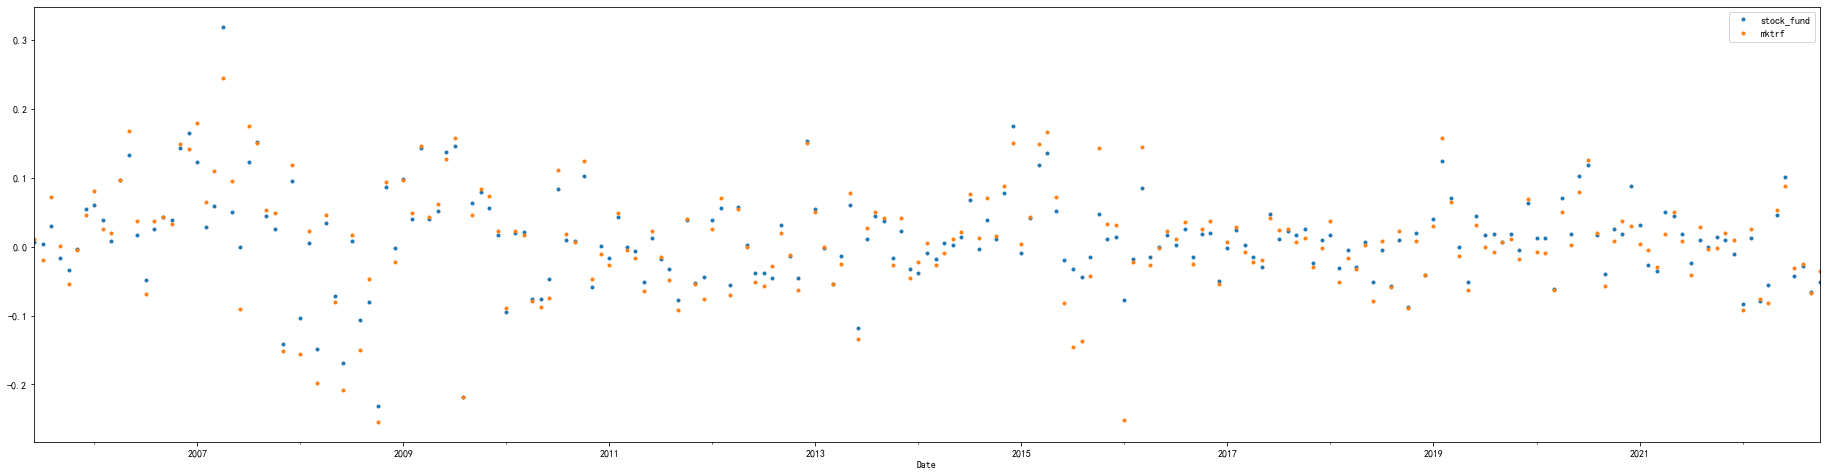

In [ ]:
regression_source[['stock_fund', 'mktrf']].plot(style='.', figsize=(32, 8))


naïve regression

In [ ]:
stock_naïve = sm.OLS(regression_source.stock_fund, regression_source[['α']]).fit()
blend_naïve = sm.OLS(regression_source.blend_fund, regression_source[['α']]).fit()
stock_naïve_excess = sm.OLS(regression_source.stock_fund - regression_source.rf, regression_source[['α']]).fit()
blend_naïve_excess = sm.OLS(regression_source.blend_fund - regression_source.rf, regression_source[['α']]).fit()


In [ ]:
pd.DataFrame(
[
[float_to_percent(stock_naïve.params[0]), stock_naïve.tvalues.iloc[0].round(3), stock_naïve.pvalues[0].round(3), yearly_return(stock_naïve.params[0])],
[float_to_percent(blend_naïve.params[0]), blend_naïve.tvalues.iloc[0].round(3), blend_naïve.pvalues[0].round(3), yearly_return(blend_naïve.params[0])],
[float_to_percent(stock_naïve_excess.params[0]), stock_naïve_excess.tvalues.iloc[0].round(3), stock_naïve_excess.pvalues[0].round(3), yearly_return(stock_naïve_excess.params[0])],
[float_to_percent(blend_naïve_excess.params[0]), blend_naïve_excess.tvalues.iloc[0].round(3), blend_naïve_excess.pvalues[0].round(3), yearly_return(blend_naïve_excess.params[0])],
],
index=['stock_naïve', 'blend_naïve', 'stock_naïve_excess', 'blend_naïve_excess'], columns=pd.Series(['α', 't', 'p', 'annual α'],\
name=f'{regression_source.index[0].year}/{regression_source.index[0].month}-{regression_source.index[-1].year}/{regression_source.index[-1].month}'))

2005/6-2022/10,α,t,p,annual α
stock_naïve,1.102%,2.377,0.018,14.05%
blend_naïve,1.057%,2.884,0.004,13.45%
stock_naïve_excess,0.912%,1.966,0.051,11.51%
blend_naïve_excess,0.867%,2.364,0.019,10.91%


CAPM regression

In [ ]:
stock_capm = sm.OLS(regression_source.stock_fund - regression_source.rf, regression_source[['α', 'mktrf']]).fit()
blend_capm = sm.OLS(regression_source.blend_fund - regression_source.rf, regression_source[['α', 'mktrf']]).fit()

In [ ]:
pd.DataFrame(
[
[float_to_percent(stock_capm.params[0]) + ' (' + str(stock_capm.tvalues.iloc[0].round(3)) + ')', \
    str(stock_capm.params[1].round(3)) + ' (' + str(stock_capm.tvalues.iloc[1].round(3)) + ')',\
         stock_capm.rsquared, yearly_return(stock_capm.params[0])],
[float_to_percent(blend_capm.params[0]) + ' (' + str(blend_capm.tvalues.iloc[0].round(3)) + ')', \
    str(blend_capm.params[1].round(3)) + ' (' + str(blend_capm.tvalues.iloc[1].round(3)) + ')', \
        blend_capm.rsquared, yearly_return(blend_capm.params[0])],
],
columns=['α', 'mktrf', 'r^2', 'annual α'], index=pd.Series(['stock_capm', 'blend_capm'], \
name=f'{regression_source.index[0].year}/{regression_source.index[0].month}-{regression_source.index[-1].year}/{regression_source.index[-1].month}')).T

2005/6-2022/10,stock_capm,blend_capm
α,0.207% (1.336),0.329% (2.154)
mktrf,0.812 (40.996),0.62 (31.741)
r^2,0.890342,0.829554
annual α,2.51%,4.02%


SVC regression

In [ ]:
stock_svc = sm.OLS(regression_source.stock_fund - regression_source.rf, regression_source[['α', 'mktrf', 'smb', 'vmg']]).fit()
blend_svc = sm.OLS(regression_source.blend_fund - regression_source.rf, regression_source[['α', 'mktrf', 'smb', 'vmg']]).fit()

In [ ]:
pd.DataFrame(
[
[float_to_percent(stock_svc.params[0]) + ' (' + str(stock_svc.tvalues.iloc[0].round(3)) + ')', \
    str(stock_svc.params[1].round(3)) + ' (' + str(stock_svc.tvalues.iloc[1].round(3)) + ')', \
        str(stock_svc.params[2].round(3)) + ' (' + str(stock_svc.tvalues.iloc[2].round(3)) + ')', \
            str(stock_svc.params[3].round(3)) + ' (' + str(stock_svc.tvalues.iloc[3].round(3)) + ')', \
                stock_svc.rsquared, yearly_return(stock_svc.params[0])],
[float_to_percent(blend_svc.params[0]) + ' (' + str(blend_svc.tvalues.iloc[0].round(3)) + ')', \
    str(blend_svc.params[1].round(3)) + ' (' + str(blend_svc.tvalues.iloc[1].round(3)) + ')', \
        str(blend_svc.params[2].round(3)) + ' (' + str(blend_svc.tvalues.iloc[2].round(3)) + ')', \
            str(blend_svc.params[3].round(3)) + ' (' + str(blend_svc.tvalues.iloc[3].round(3)) + ')', \
                blend_svc.rsquared, yearly_return(blend_svc.params[0])],
],

columns=['α', 'mktrf', 'smb', 'vmg', 'r^2', 'annual α'], index=pd.Series(['stock_svc', 'blend_svc'], \
name=f'{regression_source.index[0].year}/{regression_source.index[0].month}-{regression_source.index[-1].year}/{regression_source.index[-1].month}')).T

2005/6-2022/10,stock_svc,blend_svc
α,0.382% (2.397),0.64% (4.05)
mktrf,0.825 (43.267),0.594 (31.388)
smb,-0.183 (-5.328),-0.052 (-1.529)
vmg,-0.023 (-0.504),-0.244 (-5.448)
r^2,0.906085,0.852232
annual α,4.68%,7.96%


## **V. Fund Evaluation**

In [ ]:
import datetime
import pandas as pd
import numpy as np
from factors import *
from pandarallel import pandarallel
start_time = '2005-6'
end_time = datetime.datetime.now().strftime('%Y-%m')
pandarallel.initialize()


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


### CAPM α +

In [2]:
from factors import *

@fund_ended_check
@cache_wrapper(expire= 60 * 60 * 24 * 30)
def capm_α_generation(x):
    from sklearn.linear_model import LinearRegression
    from data.TwoStepData.regression_source import regression_source
    x = x.dropna()
    temp_dates = x.index
    temp_regression = regression_source.loc[temp_dates]
    α = LinearRegression().fit(X = temp_regression.mktrf.values.reshape(-1, 1), y = (x - temp_regression.rf).values).intercept_
    return α

all_fund_capm_α = return_of_all_fund_.loc[start_time: end_time].rolling(window = 36, min_periods = 36 - MAX_NA_NUM).parallel_apply(capm_α_generation)
all_fund_capm_α.shape


(209, 4624)

In [87]:
group_and_statistic(all_fund_capm_α, groups=5, weighting='mkt', interval=1, kind='all_time_span', time_span=24)

group0  group1  group2  group3  group4 long-short
excess α (monthly)  1.014%  1.047%  1.103%  1.239%  1.236%     0.222%
       annual α     12.87%  13.31%  14.07%  15.93%  15.89%       2.7%
       t             2.087    2.17   2.288   2.519   2.403      1.341
       R^2             0.0    -0.0     0.0     0.0    -0.0        0.0
       Obs             207     207     207     207     207        207
capm α α (monthly)   0.25%  0.295%   0.36%  0.527%  0.484%     0.234%
       annual α      3.05%    3.6%    4.4%   6.51%   5.97%      2.84%
       t             1.887   2.036   2.251   2.295   2.093        1.4
       R^2           0.927   0.911   0.892   0.786   0.801      0.002
       Obs             207     207     207     207     207        207
svc α  α (monthly)  0.426%  0.551%  0.689%  0.807%  0.996%      0.57%
       annual α      5.23%   6.82%   8.58%  10.13%  12.63%      7.06%
       t             2.974    3.57   4.165   3.231   4.282       3.36
       R^2           0.931   0.918   0.906   0.794   0.837      0.162
       Obs             207     207     207     207     207        207

In [5]:
group_and_statistic(all_fund_capm_α, groups = 5, weighting = 'mkt', interval = 1, kind = 'time_series_subsample', time_span = 24)

2005-06/2007-07 2007-08/2009-09 2009-10/2011-11  \
excess α (monthly)          -0.42%          0.126%          0.333%   
       annual α             -4.93%           1.52%           4.06%   
       t                    -0.844           0.412           0.733   
       R^2                     0.0             0.0             0.0   
       Obs                      26              26              26   
capm α α (monthly)          0.463%          0.078%          0.205%   
       annual α               5.7%           0.94%           2.49%   
       t                     0.782           0.266           0.458   
       R^2                   0.188           0.129           0.096   
       Obs                      26              26              26   
svc α  α (monthly)          0.804%          0.333%          0.156%   
       annual α             10.09%           4.08%           1.89%   
       t                     1.067            1.17           0.353   
       R^2                   0.226           0.341            0.56   
       Obs                      26              26              26   

                   2011-12/2014-01 2014-02/2016-03 2016-04/2018-05  \
excess α (monthly)          0.648%          0.134%          0.769%   
       annual α              8.06%           1.62%           9.63%   
       t                     1.956           0.168           2.734   
       R^2                     0.0             0.0             0.0   
       Obs                      26              26              26   
capm α α (monthly)           0.65%         -0.161%          0.774%   
       annual α              8.08%          -1.92%            9.7%   
       t                     1.923           -0.21            2.71   
       R^2                   0.003           0.146           0.011   
       Obs                      26              26              26   
svc α  α (monthly)          1.225%         -0.123%          0.155%   
       annual α             15.74%          -1.47%           1.87%   
       t                     4.055          -0.234           0.642   
       R^2                   0.527           0.796           0.568   
       Obs                      26              26              26   

                   2018-06/2020-07 2020-08/2022-08  
excess α (monthly)          0.189%          -0.01%  
       annual α              2.29%          -0.12%  
       t                     0.634          -0.017  
       R^2                     0.0             0.0  
       Obs                      26              25  
capm α α (monthly)          0.223%          0.094%  
       annual α              2.71%           1.13%  
       t                     0.718           0.169  
       R^2                    0.01           0.099  
       Obs                      26              25  
svc α  α (monthly)          0.102%          0.554%  
       annual α              1.24%           6.85%  
       t                     0.336           1.346  
       R^2                   0.163           0.571  
       Obs                      26              25

In [6]:
group_and_statistic(all_fund_capm_α, groups = 5, weighting = 'mkt', interval = 1, kind = 'time_series_rolling', time_span = 24)

2005-06/2007-06 2006-06/2008-06 2007-06/2009-06  \
excess α (monthly)         -0.507%         -0.624%         -0.012%   
       annual α             -5.92%          -7.24%          -0.15%   
       t                    -0.994          -1.243          -0.027   
       R^2                     0.0            -0.0             0.0   
       Obs                      25              25              25   
capm α α (monthly)          0.443%         -0.229%          0.039%   
       annual α              5.44%          -2.71%           0.47%   
       t                     0.767          -0.556           0.099   
       R^2                   0.237           0.395            0.28   
       Obs                      25              25              25   
svc α  α (monthly)          0.723%          0.078%           0.22%   
       annual α              9.03%           0.94%           2.67%   
       t                     0.967           0.168           0.543   
       R^2                   0.256           0.463           0.363   
       Obs                      25              25              25   

                   2008-06/2010-06 2009-06/2011-06 2010-06/2012-06  \
excess α (monthly)           0.22%          0.336%          0.178%   
       annual α              2.67%           4.11%           2.15%   
       t                     0.795           0.702           0.385   
       R^2                    -0.0             0.0            -0.0   
       Obs                      25              25              25   
capm α α (monthly)          0.236%          0.337%           0.12%   
       annual α              2.87%           4.12%           1.45%   
       t                     0.857            0.69           0.267   
       R^2                   0.051           0.002             0.1   
       Obs                      25              25              25   
svc α  α (monthly)          0.585%          0.506%          0.359%   
       annual α              7.25%           6.24%            4.4%   
       t                     2.274           1.037           0.861   
       R^2                   0.403           0.339           0.611   
       Obs                      25              25              25   

                   2011-06/2013-06 2012-06/2014-06 2013-06/2015-06  \
excess α (monthly)          0.556%           0.45%          0.384%   
       annual α              6.88%           5.53%            4.7%   
       t                      2.12            1.19            0.46   
       R^2                     0.0            -0.0             0.0   
       Obs                      25              25              25   
capm α α (monthly)          0.539%           0.45%         -0.082%   
       annual α              6.67%           5.54%          -0.98%   
       t                     1.989           1.165          -0.093   
       R^2                   0.006             0.0           0.082   
       Obs                      25              25              25   
svc α  α (monthly)          0.771%          1.063%          0.167%   
       annual α              9.65%          13.53%           2.03%   
       t                     2.454           3.411           0.317   
       R^2                   0.382           0.618           0.809   
       Obs                      25              25              25   

                   2014-06/2016-06 2015-06/2017-06 2016-06/2018-06  \
excess α (monthly)           0.23%          0.329%          0.758%   
       annual α               2.8%           4.02%           9.49%   
       t                      0.28           0.965           2.553   
       R^2                    -0.0             0.0             0.0   
       Obs                      25              25              25   
capm α α (monthly)          -0.09%          0.429%          0.766%   
       annual α             -1.07%           5.27%           9.59%   
       t                    -0.113           1.676           2.534   
       R^2                

### SVC α +

In [2]:
from factors import *
@fund_ended_check
# @cache_wrapper(expire= 60 * 60 * 24 * 30)
def svc_α_generation(x):
    from sklearn.linear_model import LinearRegression
    from data.TwoStepData.regression_source import regression_source
    x = x.dropna()
    temp_dates = x.index
    temp_regression = regression_source.loc[temp_dates]
    α = LinearRegression().fit(X = temp_regression[['mktrf', 'smb', 'vmg']].values, y = (x - temp_regression.rf).values).intercept_
    return α

all_fund_svc_α = return_of_all_fund_.loc[start_time: end_time].rolling(window = 36, min_periods = 36 - MAX_NA_NUM).parallel_apply(svc_α_generation)

all_fund_svc_α.shape

(210, 3131)

In [8]:
group_and_statistic(all_fund_svc_α, groups=5, weighting='mkt', interval=1, kind='all_time_span')

group0  group1  group2  group3  group4 long-short
excess α (monthly)  0.947%  1.041%  1.123%  1.284%  1.252%     0.305%
       annual α     11.97%  13.23%  14.34%  16.54%   16.1%      3.72%
       t             1.937   2.162   2.355   2.514   2.467      1.933
       R^2             0.0     0.0     0.0     0.0    -0.0       -0.0
       Obs             207     207     207     207     207        207
capm α α (monthly)  0.179%  0.287%  0.387%  0.566%  0.504%     0.324%
       annual α      2.17%    3.5%   4.74%   7.01%   6.21%      3.96%
       t             1.329   2.079   2.464   2.159    2.29      2.042
       R^2           0.925   0.919   0.893   0.741   0.815      0.006
       Obs             207     207     207     207     207        207
svc α  α (monthly)  0.232%  0.489%  0.688%  0.895%  1.072%      0.84%
       annual α      2.82%   6.02%   8.58%  11.29%  13.65%     10.56%
       t             1.554   3.284   4.191   3.137   4.973      5.898
       R^2           0.925   0.924   0.905   0.751   0.856       0.35
       Obs             207     207     207     207     207        207

In [9]:
group_and_statistic(all_fund_svc_α, groups = 5, weighting = 'mkt', interval = 1, kind = 'time_series_subsample', time_span = 24)

2005-06/2007-07 2007-08/2009-09 2009-10/2011-11  \
excess α (monthly)         -0.008%           0.34%          0.061%   
       annual α              -0.1%           4.15%           0.74%   
       t                    -0.024           1.096           0.224   
       R^2                     0.0             0.0             0.0   
       Obs                      26              26              26   
capm α α (monthly)          0.295%          0.294%         -0.004%   
       annual α              3.59%           3.59%          -0.05%   
       t                     0.655           0.983          -0.016   
       R^2                   0.045           0.112            0.07   
       Obs                      26              26              26   
svc α  α (monthly)          1.115%          0.618%         -0.038%   
       annual α             14.23%           7.67%          -0.45%   
       t                     2.379           2.275          -0.108   
       R^2                   0.391           0.414            0.25   
       Obs                      26              26              26   

                   2011-12/2014-01 2014-02/2016-03 2016-04/2018-05  \
excess α (monthly)          0.606%         -0.147%          0.591%   
       annual α              7.52%          -1.76%           7.33%   
       t                     1.465          -0.189           3.159   
       R^2                     0.0             0.0             0.0   
       Obs                      26              26              26   
capm α α (monthly)          0.609%         -0.094%          0.587%   
       annual α              7.56%          -1.12%           7.27%   
       t                     1.455          -0.116           3.097   
       R^2                   0.016           0.005           0.018   
       Obs                      26              26              26   
svc α  α (monthly)          1.361%          0.078%          0.433%   
       annual α             17.61%           0.94%           5.33%   
       t                     4.083           0.194           1.939   
       R^2                    0.63           0.875           0.162   
       Obs                      26              26              26   

                   2018-06/2020-07 2020-08/2022-08  
excess α (monthly)          0.743%          0.254%  
       annual α              9.28%           3.09%  
       t                     2.043           0.402  
       R^2                     0.0             0.0  
       Obs                      26              25  
capm α α (monthly)          0.671%           0.42%  
       annual α              8.36%           5.16%  
       t                     1.796           0.725  
       R^2                   0.031           0.204  
       Obs                      26              25  
svc α  α (monthly)          0.826%          0.922%  
       annual α             10.37%          11.64%  
       t                     2.815           2.456  
       R^2                   0.477           0.713  
       Obs                      26              25

In [10]:
group_and_statistic(all_fund_svc_α, groups = 5, weighting = 'mkt', interval = 1, kind = 'time_series_rolling', time_span = 24)

2005-06/2007-06 2006-06/2008-06 2007-06/2009-06  \
excess α (monthly)         -0.025%          0.051%          0.287%   
       annual α             -0.29%           0.61%            3.5%   
       t                    -0.068           0.128           0.803   
       R^2                     0.0             0.0             0.0   
       Obs                      25              25              25   
capm α α (monthly)           0.29%          0.248%          0.334%   
       annual α              3.53%           3.02%           4.09%   
       t                     0.633           0.646           1.168   
       R^2                   0.051           0.158           0.386   
       Obs                      25              25              25   
svc α  α (monthly)          1.126%          0.742%          0.533%   
       annual α             14.38%           9.27%           6.59%   
       t                     2.343           1.902           1.992   
       R^2                   0.391           0.391           0.547   
       Obs                      25              25              25   

                   2008-06/2010-06 2009-06/2011-06 2010-06/2012-06  \
excess α (monthly)          0.211%          0.038%          0.097%   
       annual α              2.56%           0.46%           1.17%   
       t                     0.723           0.118           0.352   
       R^2                    -0.0             0.0             0.0   
       Obs                      25              25              25   
capm α α (monthly)          0.217%          0.035%          0.059%   
       annual α              2.64%           0.42%           0.71%   
       t                     0.731           0.108           0.222   
       R^2                   0.007           0.046           0.123   
       Obs                      25              25              25   
svc α  α (monthly)          0.677%          0.297%          0.064%   
       annual α              8.44%           3.62%           0.77%   
       t                     2.486           0.853           0.256   
       R^2                   0.399           0.255           0.609   
       Obs                      25              25              25   

                   2011-06/2013-06 2012-06/2014-06 2013-06/2015-06  \
excess α (monthly)          0.466%          0.337%          0.044%   
       annual α              5.74%           4.12%           0.53%   
       t                     2.219           0.682            0.05   
       R^2                     0.0             0.0             0.0   
       Obs                      25              25              25   
capm α α (monthly)          0.418%           0.35%          0.116%   
       annual α              5.13%           4.28%            1.4%   
       t                     1.993           0.696           0.118   
       R^2                   0.073           0.012           0.002   
       Obs                      25              25              25   
svc α  α (monthly)          0.539%          1.206%          0.509%   
       annual α              6.67%          15.47%           6.28%   
       t                     2.059           3.437           1.123   
       R^2                   0.329           0.717           0.877   
       Obs                      25              25              25   

                   2014-06/2016-06 2015-06/2017-06 2016-06/2018-06  \
excess α (monthly)         -0.038%          0.245%          0.642%   
       annual α             -0.46%           2.98%           7.98%   
       t                    -0.048           1.127           3.471   
       R^2                     0.0             0.0             0.0   
       Obs                      25              25              25   
capm α α (monthly)          0.043%           0.24%          0.637%   
       annual α              0.52%           2.92%           7.91%   
       t                     0.053           1.079           3.384   
       R^2                

### CAPM α/ε ?

In [4]:
from factors import *

@fund_ended_check
@cache_wrapper(expire= 60 * 60 * 24 * 30)
def capm_α_ε_generation(x):
    
    from sklearn.linear_model import LinearRegression
    from data.TwoStepData.regression_source import regression_source
    import numpy as np
    x = x.dropna()
    temp_dates = x.index
    temp_regression = regression_source.loc[temp_dates]
    result = LinearRegression().fit(X = temp_regression.mktrf.values.reshape(-1, 1), y = (x - temp_regression.rf).values)
    α = result.intercept_
    ε = (result.predict(temp_regression.mktrf.values.reshape(-1, 1)) - (x - temp_regression.rf).values).std()
    division = α / ε

    if division < 1e3 and division > 1e-3:
        return division
    else:
        return np.nan


all_fund_capm_α_ε = return_of_all_fund_.loc[start_time: end_time].rolling(window = 36, min_periods = 36 - MAX_NA_NUM).parallel_apply(capm_α_ε_generation)

all_fund_capm_α_ε.shape

(209, 4624)

In [12]:
group_and_statistic(all_fund_capm_α_ε, groups=5, weighting='mkt', interval=1, kind='all_time_span')

group0  group1  group2  group3  group4 long-short
excess α (monthly)  1.119%  1.089%   1.08%  1.286%  1.284%     0.165%
       annual α     14.29%  13.88%  13.76%  16.57%  16.54%       2.0%
       t             2.212   2.208   2.211   2.474   2.613      1.441
       R^2             0.0    -0.0     0.0     0.0     0.0       -0.0
       Obs             205     205     205     205     205        205
capm α α (monthly)   0.36%  0.357%  0.362%  0.591%  0.569%     0.209%
       annual α       4.4%   4.37%   4.43%   7.32%   7.04%      2.54%
       t             2.152   2.011   1.933   2.086   2.858       1.87
       R^2           0.893   0.873   0.856   0.708   0.839       0.06
       Obs             205     205     205     205     205        205
svc α  α (monthly)    0.7%  0.749%   0.72%  0.806%  0.939%     0.239%
       annual α      8.73%   9.37%   8.99%  10.11%  11.87%      2.91%
       t             4.082   4.165   3.746   2.594   4.592      1.945
       R^2           0.908   0.894   0.876   0.714   0.861      0.074
       Obs             205     205     205     205     205        205

In [13]:
group_and_statistic(all_fund_capm_α_ε, groups = 5, weighting = 'mkt', interval = 1, kind = 'time_series_subsample', time_span = 24)

2005-08/2007-09 2007-10/2009-11 2009-12/2012-01  \
excess α (monthly)         -0.096%          0.295%          0.199%   
       annual α             -1.14%            3.6%           2.41%   
       t                    -0.197           0.777           0.809   
       R^2                    -0.0            -0.0             0.0   
       Obs                      26              26              26   
capm α α (monthly)          0.307%           0.19%          0.125%   
       annual α              3.75%           2.31%           1.51%   
       t                     0.479           0.622            0.52   
       R^2                   0.037           0.383           0.108   
       Obs                      26              26              26   
svc α  α (monthly)          0.241%          0.322%          0.103%   
       annual α              2.93%           3.93%           1.24%   
       t                     0.291           0.928           0.374   
       R^2                   0.063           0.419            0.39   
       Obs                      26              26              26   

                   2012-02/2014-03 2014-04/2016-05 2016-06/2018-06  \
excess α (monthly)          0.337%          0.364%          0.508%   
       annual α              4.12%           4.45%           6.27%   
       t                     1.636           1.188           2.047   
       R^2                     0.0             0.0            -0.0   
       Obs                      26              26              25   
capm α α (monthly)           0.35%           0.44%          0.507%   
       annual α              4.28%           5.41%           6.25%   
       t                     1.678           1.414           1.996   
       R^2                   0.025           0.053           0.001   
       Obs                      26              26              25   
svc α  α (monthly)          0.567%          0.678%         -0.079%   
       annual α              7.03%           8.44%          -0.94%   
       t                     3.247           1.779          -0.337   
       R^2                     0.6           0.281           0.492   
       Obs                      26              26              25   

                   2018-07/2020-07 2020-08/2022-08  
excess α (monthly)          0.134%         -0.433%  
       annual α              1.61%          -5.07%  
       t                     0.602          -1.115  
       R^2                     0.0             0.0  
       Obs                      25              25  
capm α α (monthly)          0.215%          -0.38%  
       annual α              2.61%          -4.47%  
       t                     0.986          -0.979  
       R^2                   0.117           0.054  
       Obs                      25              25  
svc α  α (monthly)          0.111%         -0.371%  
       annual α              1.34%          -4.36%  
       t                     0.605          -0.887  
       R^2                   0.445           0.056  
       Obs                      25              25

In [14]:
group_and_statistic(all_fund_capm_α_ε, groups = 5, weighting = 'mkt', interval = 1, kind = 'time_series_rolling', time_span = 24)

2005-08/2007-08 2006-08/2008-08 2007-08/2009-08  \
excess α (monthly)         -0.106%         -0.063%          0.254%   
       annual α             -1.26%          -0.75%           3.09%   
       t                    -0.209          -0.126           0.642   
       R^2                    -0.0             0.0             0.0   
       Obs                      25              25              25   
capm α α (monthly)          0.301%          0.115%          0.108%   
       annual α              3.67%           1.39%           1.31%   
       t                     0.452            0.24           0.348   
       R^2                   0.037           0.142           0.411   
       Obs                      25              25              25   
svc α  α (monthly)          0.207%           0.14%          0.261%   
       annual α              2.52%           1.69%           3.17%   
       t                     0.245            0.26           0.786   
       R^2                   0.071           0.158            0.46   
       Obs                      25              25              25   

                   2008-08/2010-08 2009-08/2011-08 2010-08/2012-08  \
excess α (monthly)          0.376%          0.208%           0.12%   
       annual α              4.61%           2.52%           1.45%   
       t                     1.045           0.808           0.507   
       R^2                     0.0             0.0             0.0   
       Obs                      25              25              25   
capm α α (monthly)          0.502%          0.192%          0.061%   
       annual α               6.2%           2.33%           0.74%   
       t                     1.697            0.77           0.258   
       R^2                    0.36           0.101           0.066   
       Obs                      25              25              25   
svc α  α (monthly)          0.664%         -0.073%          0.097%   
       annual α              8.27%          -0.87%           1.17%   
       t                     1.964          -0.253           0.339   
       R^2                   0.433           0.461           0.304   
       Obs                      25              25              25   

                   2011-08/2013-08 2012-08/2014-08 2013-08/2015-08  \
excess α (monthly)          0.368%          0.516%          0.508%   
       annual α              4.51%           6.37%           6.27%   
       t                     2.317           2.231           1.706   
       R^2                    -0.0             0.0             0.0   
       Obs                      25              25              25   
capm α α (monthly)          0.378%          0.476%          0.473%   
       annual α              4.63%           5.86%           5.83%   
       t                     2.364           2.031           1.526   
       R^2                   0.033           0.045           0.011   
       Obs                      25              25              25   
svc α  α (monthly)           0.55%          0.452%            0.7%   
       annual α               6.8%           5.56%           8.73%   
       t                     2.907           2.434           2.632   
       R^2                   0.263           0.664           0.601   
       Obs                      25              25              25   

                   2014-08/2016-08 2015-08/2017-08 2016-08/2018-08  \
excess α (monthly)          0.317%          0.133%          0.573%   
       annual α              3.87%           1.61%           7.09%   
       t                     1.002            0.55           2.244   
       R^2                    -0.0            -0.0             0.0   
       Obs                      25              25              25   
capm α α (monthly)          0.384%          0.187%          0.586%   
       annual α               4.7%           2.26%           7.27%   
       t                     1.206           0.907           2.229   
       R^2                

### SVC α/ε

In [5]:
from factors import *

@fund_ended_check
@cache_wrapper(expire= 60 * 60 * 24 * 30)
def svc_α_ε_generation(x):
    from sklearn.linear_model import LinearRegression
    from data.TwoStepData.regression_source import regression_source
    import numpy as np
    x = x.dropna()
    temp_dates = x.index
    temp_regression = regression_source.loc[temp_dates]
    result = LinearRegression().fit(X = temp_regression[['mktrf', 'smb', 'vmg']].values, y = (x - temp_regression.rf).values)
    α = result.intercept_
    ε = (result.predict(temp_regression[['mktrf', 'smb', 'vmg']].values) - (x - temp_regression.rf).values).std()
    division = α / ε

    if division < 1e3 and division > 1e-3:
        return division
    else:
        return np.nan

all_fund_svc_α_ε = return_of_all_fund_.loc[start_time: end_time].rolling(window = 36, min_periods = 36 - MAX_NA_NUM).parallel_apply(svc_α_ε_generation)

all_fund_svc_α_ε.shape

(209, 4624)

In [16]:
group_and_statistic(all_fund_svc_α_ε, groups=5, weighting='mkt', interval=1, kind='all_time_span')

group0  group1  group2  group3  group4 long-short
excess α (monthly)  1.037%  1.061%  1.132%  1.365%  1.269%     0.232%
       annual α     13.18%   13.5%  14.46%  17.67%  16.34%      2.82%
       t             2.086   2.165   2.252   2.555   2.485      1.981
       R^2             0.0     0.0     0.0     0.0    -0.0        0.0
       Obs             203     203     203     203     203        203
capm α α (monthly)  0.262%  0.318%  0.366%   0.64%  0.502%      0.24%
       annual α      3.19%   3.88%   4.48%   7.95%   6.19%      2.92%
       t             1.694   1.695   1.964   2.117   2.434      2.035
       R^2           0.905   0.856   0.865   0.686    0.84      0.002
       Obs             203     203     203     203     203        203
svc α  α (monthly)  0.531%  0.651%  0.746%  0.863%  1.041%      0.51%
       annual α      6.56%   8.09%   9.33%  10.86%  13.23%       6.3%
       t             3.264   3.344   3.937   2.607   5.248      4.438
       R^2           0.914   0.873   0.885   0.691   0.878      0.222
       Obs             203     203     203     203     203        203

In [17]:
group_and_statistic(all_fund_svc_α_ε, groups = 5, weighting = 'mkt', interval = 1, kind = 'time_series_subsample', time_span = 24)

2005-10/2007-11 2007-12/2010-01 2010-02/2012-03  \
excess α (monthly)          0.412%          0.264%         -0.038%   
       annual α              5.06%           3.22%          -0.46%   
       t                     1.112           0.751          -0.199   
       R^2                     0.0             0.0             0.0   
       Obs                      26              26              26   
capm α α (monthly)          0.231%          0.144%         -0.079%   
       annual α               2.8%           1.75%          -0.95%   
       t                      0.48           0.532           -0.42   
       R^2                   0.015           0.434           0.084   
       Obs                      26              26              26   
svc α  α (monthly)          0.884%          0.322%          0.132%   
       annual α             11.13%           3.93%            1.6%   
       t                     1.435           1.094           0.876   
       R^2                   0.127           0.492            0.68   
       Obs                      26              26              26   

                   2012-04/2014-04 2014-05/2016-05 2016-06/2018-06  \
excess α (monthly)           0.14%          0.268%          0.222%   
       annual α              1.69%           3.26%            2.7%   
       t                     0.383           0.614           1.126   
       R^2                     0.0            -0.0            -0.0   
       Obs                      25              25              25   
capm α α (monthly)          0.173%          0.222%          0.226%   
       annual α              2.09%            2.7%           2.75%   
       t                     0.484           0.489           1.121   
       R^2                   0.088            0.01           0.005   
       Obs                      25              25              25   
svc α  α (monthly)          0.707%           0.16%          0.321%   
       annual α              8.83%           1.94%           3.92%   
       t                      2.14           0.397           1.248   
       R^2                   0.532           0.642           0.024   
       Obs                      25              25              25   

                   2018-07/2020-07 2020-08/2022-08  
excess α (monthly)          0.467%           0.12%  
       annual α              5.75%           1.45%  
       t                     2.388           0.267  
       R^2                     0.0            -0.0  
       Obs                      25              25  
capm α α (monthly)          0.541%          0.228%  
       annual α              6.69%           2.78%  
       t                      2.83           0.542  
       R^2                   0.125           0.171  
       Obs                      25              25  
svc α  α (monthly)          0.579%          0.482%  
       annual α              7.17%           5.94%  
       t                     3.447           1.358  
       R^2                   0.403           0.494  
       Obs                      25              25

In [18]:
group_and_statistic(all_fund_svc_α_ε, groups = 5, weighting = 'mkt', interval = 1, kind = 'time_series_rolling', time_span = 24)

2005-10/2007-10 2006-10/2008-10 2007-10/2009-10  \
excess α (monthly)          0.527%          0.971%          0.252%   
       annual α              6.51%           12.3%           3.07%   
       t                     1.437           2.422           0.643   
       R^2                     0.0             0.0            -0.0   
       Obs                      25              25              25   
capm α α (monthly)          0.297%          1.017%          0.119%   
       annual α              3.63%          12.91%           1.44%   
       t                     0.639           2.527           0.417   
       R^2                   0.028           0.047           0.497   
       Obs                      25              25              25   
svc α  α (monthly)          0.883%          1.284%          0.304%   
       annual α             11.12%          16.54%           3.71%   
       t                     1.472           2.952           0.967   
       R^2                   0.125           0.146           0.546   
       Obs                      25              25              25   

                   2008-10/2010-10 2009-10/2011-10 2010-10/2012-10  \
excess α (monthly)         -0.194%          0.046%          0.001%   
       annual α              -2.3%           0.55%           0.01%   
       t                    -0.783           0.245           0.004   
       R^2                    -0.0            -0.0             0.0   
       Obs                      25              25              25   
capm α α (monthly)         -0.014%         -0.002%          0.047%   
       annual α             -0.17%          -0.03%           0.57%   
       t                     -0.06          -0.014           0.301   
       R^2                   0.227           0.145           0.025   
       Obs                      25              25              25   
svc α  α (monthly)          0.037%         -0.008%          0.133%   
       annual α              0.45%          -0.09%           1.61%   
       t                     0.132          -0.039           0.855   
       R^2                   0.341           0.454           0.539   
       Obs                      25              25              25   

                   2011-10/2013-10 2012-10/2014-10 2013-10/2015-10  \
excess α (monthly)          0.152%          0.271%           0.32%   
       annual α              1.85%            3.3%           3.91%   
       t                     0.608           0.669           0.628   
       R^2                    -0.0             0.0             0.0   
       Obs                      25              25              25   
capm α α (monthly)          0.169%          0.139%          0.229%   
       annual α              2.04%           1.68%           2.79%   
       t                     0.731           0.342           0.425   
       R^2                   0.188           0.084           0.015   
       Obs                      25              25              25   
svc α  α (monthly)          0.673%          0.836%          0.223%   
       annual α              8.38%          10.51%           2.71%   
       t                       2.8           2.225           0.488   
       R^2                   0.506             0.6           0.633   
       Obs                      25              25              25   

                   2014-10/2016-10 2015-10/2017-10 2016-10/2018-10  \
excess α (monthly)           0.11%         -0.038%          0.424%   
       annual α              1.33%          -0.46%           5.21%   
       t                     0.269          -0.209           2.299   
       R^2                     0.0             0.0            -0.0   
       Obs                      25              25              25   
capm α α (monthly)          0.068%         -0.039%          0.419%   
       annual α              0.82%          -0.46%           5.14%   
       t                     0.163          -0.207           2.168   
       R^2                

### IC : Industry Concentration ?

In [19]:
import pandas as pd
import numpy as np
from factors import *
from data.CSMAR.TRD_Mnth import csmar_monthly_stock
from data.TwoStepData.invest_detail import invest_detail
from data.TwoStepData.return_of_all_fund import return_of_all_fund
from data.JoinQuant.jq_stock_classification import jq_stock_classification

auth success 


In [20]:
return_of_all_fund_ = return_of_all_fund.unstack(0).loc[start_time: end_time]

invest_detail_ = pd.merge(invest_detail, jq_stock_classification[['Stkcd', 'Indnme']], on='Stkcd', validate='m:1')

month_mkt_value_ = pd.merge(csmar_monthly_stock, jq_stock_classification, on='Stkcd', validate='m:1')
month_mkt_value_ = month_mkt_value_.groupby(['Date', 'Indnme']).apply(lambda x: x.Msmvttl.sum())
month_mkt_value_ = month_mkt_value_.unstack().div(month_mkt_value_.unstack().sum(axis=1), axis=0).fillna(0)


In [21]:
invest_industry_sum = invest_detail_.groupby(['Symbol', 'Date', 'Indnme']).apply(lambda x: x.Proportion.sum())

In [22]:
invest_industry_proportion = invest_industry_sum / invest_industry_sum.groupby(level=[0, 1]).sum()
unstacked = invest_industry_proportion.unstack(level=[0, 2]).T

In [23]:
all_quarters = pd.date_range('2000-1', datetime.datetime.now().strftime('%Y-%m'), freq='q').to_period('M')

In [24]:
invest_industry_proportion = invest_industry_sum / invest_industry_sum.groupby(level=[0, 1]).sum()
unstacked = invest_industry_proportion.unstack(level=[0, 2]).T

In [25]:
unstacked.loc[:, unstacked.columns.isin(all_quarters)] = unstacked.loc[:, unstacked.columns.isin(all_quarters)].fillna(0)

In [26]:
unstacked[(datetime.datetime.now() + pd.offsets.QuarterEnd(0) - pd.offsets.MonthEnd(1)).strftime('%Y-%m')] = np.nan
unstacked = unstacked.T
invest_industry_proportion = unstacked.resample('M').ffill().fillna(method='ffill')
invest_industry_proportion = invest_industry_proportion.stack(0).swaplevel().sort_index().fillna(0)

month_mkt_value_ = pd.merge(invest_industry_proportion.reset_index()[['Symbol', 'Date']], month_mkt_value_, on='Date')\
    .set_index(['Symbol', 'Date']).sort_index()

In [27]:
industry_concentration = ((invest_industry_proportion - month_mkt_value_) ** 2).sum(axis=1)
industry_concentration = industry_concentration.unstack().T.loc[start_time: end_time]

co_funds = np.intersect1d(industry_concentration.columns, return_of_all_fund_.columns)
industry_concentration = industry_concentration[co_funds]

industry_concentration.shape

(209, 621)

In [28]:
group_and_statistic(industry_concentration, groups=5, weighting='mkt', interval=1, kind='all_time_span')

group0  group1  group2  group3  group4 long-short
excess α (monthly)  1.147%  1.289%  1.082%  1.106%  1.015%    -0.133%
       annual α     14.67%  16.62%  13.78%  14.11%  12.88%     -1.58%
       t             2.356   2.484   2.234   2.239   1.967     -0.985
       R^2             0.0     0.0     0.0     0.0     0.0        0.0
       Obs             207     207     207     207     207        207
capm α α (monthly)  0.386%  0.561%  0.342%   0.36%  0.233%    -0.153%
       annual α      4.73%   6.95%   4.18%    4.4%   2.84%     -1.82%
       t             2.732   2.095    1.98   1.902   1.202     -1.128
       R^2           0.917   0.738   0.875   0.856   0.861      0.008
       Obs             207     207     207     207     207        207
svc α  α (monthly)  0.569%   0.65%   0.67%  0.715%  0.702%     0.132%
       annual α      7.05%   8.09%   8.34%   8.92%   8.75%       1.6%
       t             3.705   2.191    3.72   3.631   3.588      0.971
       R^2           0.921   0.739    0.89   0.873   0.885      0.181
       Obs             207     207     207     207     207        207

In [29]:
group_and_statistic(industry_concentration, groups=5, weighting='mkt', interval=1, kind='time_series_subsample', time_span=24)

2005-06/2007-07 2007-08/2009-09 2009-10/2011-11  \
excess α (monthly)         -0.441%         -0.554%         -0.047%   
       annual α             -5.17%          -6.45%          -0.56%   
       t                    -0.963          -1.589          -0.274   
       R^2                    -0.0             0.0             0.0   
       Obs                      26              26              26   
capm α α (monthly)           0.05%         -0.483%         -0.075%   
       annual α               0.6%          -5.64%          -0.89%   
       t                     0.085           -1.53          -0.426   
       R^2                   0.068           0.219           0.032   
       Obs                      26              26              26   
svc α  α (monthly)         -0.129%         -0.442%         -0.088%   
       annual α             -1.53%          -5.18%          -1.05%   
       t                    -0.173          -1.347          -0.397   
       R^2                   0.111           0.322           0.222   
       Obs                      26              26              26   

                   2011-12/2014-01 2014-02/2016-03 2016-04/2018-05  \
excess α (monthly)          0.201%         -0.328%         -0.024%   
       annual α              2.44%          -3.87%          -0.29%   
       t                      0.59          -0.725          -0.102   
       R^2                     0.0             0.0             0.0   
       Obs                      26              26              26   
capm α α (monthly)          0.208%         -0.426%         -0.036%   
       annual α              2.52%          -4.99%          -0.43%   
       t                     0.625          -0.928          -0.155   
       R^2                   0.087            0.05           0.076   
       Obs                      26              26              26   
svc α  α (monthly)           0.55%          0.001%          0.425%   
       annual α              6.81%           0.01%           5.22%   
       t                     2.137           0.002           1.841   
       R^2                   0.675            0.49           0.445   
       Obs                      26              26              26   

                   2018-06/2020-07 2020-08/2022-08  
excess α (monthly)          0.277%         -0.145%  
       annual α              3.38%          -1.72%  
       t                     0.746          -0.258  
       R^2                    -0.0             0.0  
       Obs                      26              25  
capm α α (monthly)          0.154%          -0.03%  
       annual α              1.87%          -0.35%  
       t                     0.417          -0.055  
       R^2                   0.089           0.125  
       Obs                      26              25  
svc α  α (monthly)          0.309%          0.274%  
       annual α              3.77%           3.34%  
       t                      0.86           0.542  
       R^2                   0.247           0.337  
       Obs                      26              25

In [30]:
group_and_statistic(industry_concentration, groups=5, weighting='mkt', interval=1, kind='time_series_rolling', time_span=24)

2005-06/2007-06 2006-06/2008-06 2007-06/2009-06  \
excess α (monthly)         -0.335%         -0.955%         -0.618%   
       annual α             -3.94%         -10.88%          -7.17%   
       t                    -0.722          -1.907          -1.648   
       R^2                     0.0             0.0            -0.0   
       Obs                      25              25              25   
capm α α (monthly)          0.063%          -0.91%         -0.648%   
       annual α              0.75%         -10.39%           -7.5%   
       t                     0.107          -1.729          -1.816   
       R^2                    0.05           0.005           0.135   
       Obs                      25              25              25   
svc α  α (monthly)         -0.086%         -1.003%         -0.633%   
       annual α             -1.03%         -11.39%          -7.33%   
       t                    -0.114           -1.63          -1.789   
       R^2                   0.078            0.05           0.282   
       Obs                      25              25              25   

                   2008-06/2010-06 2009-06/2011-06 2010-06/2012-06  \
excess α (monthly)         -0.253%         -0.031%          0.018%   
       annual α             -2.99%          -0.37%           0.21%   
       t                    -0.995          -0.163           0.086   
       R^2                     0.0             0.0             0.0   
       Obs                      25              25              25   
capm α α (monthly)         -0.278%         -0.032%          0.003%   
       annual α             -3.28%          -0.38%           0.03%   
       t                    -1.148          -0.164           0.013   
       R^2                   0.134           0.007           0.034   
       Obs                      25              25              25   
svc α  α (monthly)         -0.133%          0.006%           0.26%   
       annual α             -1.58%           0.07%           3.16%   
       t                    -0.487           0.024           1.078   
       R^2                   0.202           0.096           0.353   
       Obs                      25              25              25   

                   2011-06/2013-06 2012-06/2014-06 2013-06/2015-06  \
excess α (monthly)          0.159%         -0.171%         -0.023%   
       annual α              1.92%          -2.03%          -0.28%   
       t                      0.59          -0.417          -0.047   
       R^2                    -0.0            -0.0             0.0   
       Obs                      25              25              25   
capm α α (monthly)          0.094%         -0.137%         -0.171%   
       annual α              1.14%          -1.63%          -2.03%   
       t                     0.352           -0.35          -0.312   
       R^2                   0.079           0.132           0.022   
       Obs                      25              25              25   
svc α  α (monthly)          0.205%          0.287%          0.518%   
       annual α              2.49%            3.5%            6.4%   
       t                     0.683            1.06           1.222   
       R^2                   0.463           0.756           0.664   
       Obs                      25              25              25   

                   2014-06/2016-06 2015-06/2017-06 2016-06/2018-06  \
excess α (monthly)         -0.333%         -0.509%         -0.087%   
       annual α             -3.93%          -5.94%          -1.04%   
       t                    -0.715          -1.851          -0.326   
       R^2                    -0.0             0.0             0.0   
       Obs                      25              25              25   
capm α α (monthly)         -0.436%         -0.467%         -0.106%   
       annual α              -5.1%          -5.46%          -1.26%   
       t                    -0.915          -1.773          -0.401   
       R^2                

### AS : Active Share ?

In [31]:
import numpy as np

from factors import *
from data.CSMAR.index_weight import *
from data.TwoStepData.invest_detail import invest_detail
from data.TwoStepData.return_of_all_fund import return_of_all_fund
from data.JoinQuant.jq_stock_classification import jq_stock_classification

In [32]:
return_of_all_fund_ = return_of_all_fund.unstack(0).loc[start_time: end_time]

invest_detail_ = pd.merge(invest_detail, jq_stock_classification[['Stkcd', 'Indnme']], on='Stkcd', validate='m:1')

In [33]:
invest_detail_ = invest_detail_.drop_duplicates(['Symbol', 'Date', 'Stkcd'])
invest_detail_ = invest_detail_[invest_detail_.Date >= start_time]
invest_detail_ = invest_detail_.pivot(index=['Symbol', 'Date'], columns='Stkcd', values='Proportion')
invest_detail_ = invest_detail_.div(invest_detail_.sum(axis=1), axis=0) * 100


In [34]:
hs300_weight_in_csmar_form = pd.DataFrame(columns=csmar_hs300_weight.columns, index=invest_detail_.index, \
    data=pd.merge(csmar_hs300_weight, pd.Series(invest_detail_.index.get_level_values(1).values, name='Enddt'), on='Enddt', how='right').iloc[:, 1:].values)

hs300_co_stocks = np.intersect1d(invest_detail_.columns, hs300_weight_in_csmar_form.columns)
hs300_AS = (np.abs(hs300_weight_in_csmar_form[hs300_co_stocks] - invest_detail_[hs300_co_stocks])).sum(axis=1) / 2

sz50_weight_in_csmar_form = pd.DataFrame(columns=csmar_sz50_weight.columns, index=invest_detail_.index, \
    data=pd.merge(csmar_sz50_weight, pd.Series(invest_detail_.index.get_level_values(1).values, name='Enddt'), on='Enddt', how='right').iloc[:, 1:].values)

sz50_co_stocks = np.intersect1d(invest_detail_.columns, csmar_sz50_weight.columns)
sz50_AS = (np.abs(sz50_weight_in_csmar_form[sz50_co_stocks] - invest_detail_[sz50_co_stocks])).sum(axis=1) / 2

zz500_weight_in_csmar_form = pd.DataFrame(columns=csmar_zz500_weight.columns, index=invest_detail_.index, \
    data=pd.merge(csmar_zz500_weight, pd.Series(invest_detail_.index.get_level_values(1).values, name='Enddt'), on='Enddt', how='right').iloc[:, 1:].values)

zz500_co_stocks = np.intersect1d(invest_detail_.columns, csmar_zz500_weight.columns)
zz500_AS = (np.abs(zz500_weight_in_csmar_form[zz500_co_stocks] - invest_detail_[zz500_co_stocks])).sum(axis=1) / 2

In [35]:
active_share = pd.concat([hs300_AS, zz500_AS, sz50_AS], axis=1).replace(0, np.inf).min(axis=1).unstack(0)
co_funds = np.intersect1d(active_share.columns, return_of_all_fund_.columns)
active_share = active_share[co_funds].replace(np.inf, np.nan).loc[start_time: end_time].dropna(how='all', axis=1).apply(lambda x: x[:x[pd.notna(x)].index[-1]].ffill())
active_share = active_share.T
active_share[(datetime.datetime.now() + pd.offsets.QuarterEnd(0) - pd.offsets.MonthEnd(1)).strftime('%Y-%m')] = np.nan
active_share = active_share.T.resample('M').ffill().fillna(method='ffill').loc[: (datetime.datetime.now() - pd.offsets.MonthEnd(1)).strftime('%Y-%m')]
active_share.shape

(209, 621)

In [36]:
group_and_statistic(active_share, groups=5, weighting='mkt', interval=1, kind='all_time_span')

group0  group1  group2  group3  group4 long-short
excess α (monthly)  1.133%   1.04%  1.159%  1.319%  1.005%    -0.128%
       annual α     14.48%  13.21%  14.83%  17.02%  12.75%     -1.53%
       t             2.343   2.146   2.357   2.556   2.054     -1.291
       R^2             0.0     0.0     0.0    -0.0     0.0       -0.0
       Obs             207     207     207     207     207        207
capm α α (monthly)  0.395%  0.298%  0.413%  0.606%  0.238%    -0.157%
       annual α      4.84%   3.63%   5.07%   7.52%   2.89%     -1.87%
       t             2.283   1.752   2.247   2.181   1.726     -1.595
       R^2           0.874   0.879   0.863   0.715   0.922      0.032
       Obs             207     207     207     207     207        207
svc α  α (monthly)  0.763%  0.668%  0.745%  0.758%  0.495%    -0.268%
       annual α      9.55%   8.32%   9.31%   9.48%    6.1%     -3.17%
       t             4.215   3.846   3.938   2.466   3.382     -2.495
       R^2           0.888   0.897   0.882   0.717   0.929      0.064
       Obs             207     207     207     207     207        207

In [37]:
group_and_statistic(active_share, groups=5, weighting='mkt', interval=1, kind='time_series_subsample', time_span=24)

2005-06/2007-07 2007-08/2009-09 2009-10/2011-11  \
excess α (monthly)         -0.404%         -0.326%         -0.108%   
       annual α             -4.74%          -3.84%          -1.29%   
       t                    -1.202          -0.982          -0.453   
       R^2                    -0.0             0.0             0.0   
       Obs                      26              26              26   
capm α α (monthly)         -0.677%         -0.246%         -0.031%   
       annual α             -7.82%          -2.91%          -0.37%   
       t                    -1.556          -0.867          -0.134   
       R^2                   0.039           0.304           0.126   
       Obs                      26              26              26   
svc α  α (monthly)         -0.581%         -0.246%          0.246%   
       annual α             -6.76%          -2.91%           2.99%   
       t                    -1.039          -0.811           0.779   
       R^2                   0.063           0.364            0.19   
       Obs                      26              26              26   

                   2011-12/2014-01 2014-02/2016-03 2016-04/2018-05  \
excess α (monthly)          0.048%           0.14%         -0.205%   
       annual α              0.58%            1.7%          -2.43%   
       t                     0.247           0.823          -0.975   
       R^2                     0.0             0.0             0.0   
       Obs                      26              26              26   
capm α α (monthly)          0.043%          0.078%         -0.193%   
       annual α              0.51%           0.93%           -2.3%   
       t                     0.234           0.473          -0.945   
       R^2                   0.164           0.145           0.091   
       Obs                      26              26              26   
svc α  α (monthly)           0.07%          0.056%         -0.436%   
       annual α              0.84%           0.68%          -5.11%   
       t                     0.297           0.314          -1.784   
       R^2                   0.168            0.48           0.204   
       Obs                      26              26              26   

                   2018-06/2020-07 2020-08/2022-08  
excess α (monthly)         -0.315%          0.156%  
       annual α             -3.71%           1.89%  
       t                    -1.289           0.353  
       R^2                     0.0             0.0  
       Obs                      26              25  
capm α α (monthly)          -0.23%          0.061%  
       annual α             -2.73%           0.73%  
       t                     -0.95           0.144  
       R^2                   0.098           0.137  
       Obs                      26              25  
svc α  α (monthly)         -0.238%         -0.126%  
       annual α             -2.82%           -1.5%  
       t                    -0.922          -0.316  
       R^2                   0.099           0.341  
       Obs                      26              25

In [38]:
group_and_statistic(active_share, groups=5, weighting='mkt', interval=1, kind='time_series_rolling', time_span=24)


2005-06/2007-06 2006-06/2008-06 2007-06/2009-06  \
excess α (monthly)         -0.515%         -0.322%         -0.187%   
       annual α             -6.01%          -3.79%          -2.22%   
       t                     -1.56          -0.796          -0.512   
       R^2                     0.0             0.0            -0.0   
       Obs                      25              25              25   
capm α α (monthly)         -0.692%          -0.52%         -0.236%   
       annual α              -8.0%          -6.06%           -2.8%   
       t                    -1.634          -1.325          -0.815   
       R^2                    0.02           0.153           0.398   
       Obs                      25              25              25   
svc α  α (monthly)         -0.662%         -0.695%         -0.197%   
       annual α             -7.66%          -8.03%          -2.34%   
       t                    -1.229          -1.504          -0.672   
       R^2                   0.077           0.178           0.476   
       Obs                      25              25              25   

                   2008-06/2010-06 2009-06/2011-06 2010-06/2012-06  \
excess α (monthly)         -0.292%         -0.126%         -0.041%   
       annual α             -3.44%          -1.51%          -0.49%   
       t                    -1.266          -0.553          -0.171   
       R^2                     0.0             0.0             0.0   
       Obs                      25              25              25   
capm α α (monthly)         -0.323%         -0.129%         -0.008%   
       annual α             -3.81%          -1.54%           -0.1%   
       t                      -1.6          -0.571          -0.035   
       R^2                   0.265           0.062           0.121   
       Obs                      25              25              25   
svc α  α (monthly)         -0.292%         -0.204%          0.433%   
       annual α             -3.45%          -2.43%           5.32%   
       t                    -1.263          -0.745           1.501   
       R^2                   0.304           0.084           0.297   
       Obs                      25              25              25   

                   2011-06/2013-06 2012-06/2014-06 2013-06/2015-06  \
excess α (monthly)         -0.019%          0.102%            0.2%   
       annual α             -0.22%           1.23%           2.42%   
       t                    -0.092           0.584           1.181   
       R^2                     0.0             0.0             0.0   
       Obs                      25              25              25   
capm α α (monthly)          0.056%          0.087%          0.129%   
       annual α              0.67%           1.04%           1.56%   
       t                     0.295           0.526           0.709   
       R^2                   0.186           0.152           0.046   
       Obs                      25              25              25   
svc α  α (monthly)         -0.001%          0.171%          0.303%   
       annual α             -0.01%           2.07%            3.7%   
       t                    -0.004           0.805           1.577   
       R^2                   0.221            0.17           0.386   
       Obs                      25              25              25   

                   2014-06/2016-06 2015-06/2017-06 2016-06/2018-06  \
excess α (monthly)          0.263%           0.19%          -0.19%   
       annual α              3.21%            2.3%          -2.25%   
       t                     1.384           1.107          -0.841   
       R^2                    -0.0             0.0            -0.0   
       Obs                      25              25              25   
capm α α (monthly)          0.195%          0.217%         -0.173%   
       annual α              2.36%           2.64%          -2.05%   
       t                     1.044           1.336          -0.781   
       R^2                

### Connected Companies Portfolio CAPM +

In [6]:
import numpy as np
import pandas as pd
from factors import *
import dask.array as da
from data.TwoStepData.invest_detail import invest_detail
from data.TwoStepData.filtered_funds import filtered_funds

In [7]:
invest_detail.loc[:, 'Symbol'] = invest_detail.Symbol.str.zfill(6)
invest_detail = invest_detail[invest_detail.Date.between(start_time, end_time)]
v_mnt = invest_detail.pivot(index=['Date', 'Stkcd'], columns='Symbol', values='Proportion')
invest_detail_matrix = v_mnt.values.copy()
invest_detail_matrix[np.isnan(invest_detail_matrix)] = 0
proportion_sum = da.array(invest_detail_matrix).sum(axis=1).compute()

v_mnt = v_mnt.loc[proportion_sum != 0]
proportion_sum = proportion_sum[proportion_sum != 0]
v_mnt = pd.DataFrame(index=v_mnt.index, columns=v_mnt.columns, data=v_mnt.values / proportion_sum.reshape(-1, 1))



In [8]:
@fund_ended_check
@cache_wrapper(expire= 60 * 60 * 24 * 30)
def capm_α_ε_generation(x):
    
    from sklearn.linear_model import LinearRegression
    from data.TwoStepData.regression_source import regression_source
    import numpy as np
    x = x.dropna()
    temp_dates = x.index
    temp_regression = regression_source.loc[temp_dates]
    result = LinearRegression().fit(X = temp_regression.mktrf.values.reshape(-1, 1), y = (x - temp_regression.rf).values)
    α = result.intercept_
    ε = (result.predict(temp_regression.mktrf.values.reshape(-1, 1)) - (x - temp_regression.rf).values).std()
    division = α / ε

    if division < 1e3 and division > 1e-3:
        return division
    else:
        return np.nan

all_fund_capm_α_ε = return_of_all_fund_.loc[start_time: end_time].rolling(window = 36, min_periods = 36 - MAX_NA_NUM).parallel_apply(capm_α_ε_generation)

In [9]:
a_mt = pd.merge(pd.Series(index=v_mnt.index.get_level_values(0), data=[np.nan] * len(v_mnt.index), name='temp'), all_fund_capm_α_ε, on='Date', how='left')

co_funds = np.intersect1d(a_mt.columns, v_mnt.columns)
δ_nt = da.array(v_mnt[co_funds].fillna(0).values * a_mt[co_funds].fillna(0).values).sum(axis=1).compute()
δ_nt = pd.Series(index=v_mnt.index, data=δ_nt)

w_int = invest_detail.pivot(index=['Date', 'Stkcd'], columns='Symbol', values='Proportion')
ccp_capm_it = w_int.loc[δ_nt.index].multiply(δ_nt, axis=0).groupby(level=0).sum().replace(0, np.nan).dropna(how='all', axis=1).apply(lambda x: x[:x[pd.notna(x)].index[-1]].ffill())
ccp_capm_it = ccp_capm_it.T
ccp_capm_it[(datetime.datetime.now() + pd.offsets.QuarterEnd(0) - pd.offsets.MonthEnd(1)).strftime('%Y-%m')] = np.nan
ccp_capm_it = ccp_capm_it.T.resample('M').ffill().fillna(method='ffill').loc[: (datetime.datetime.now() - pd.offsets.MonthEnd(1)).strftime('%Y-%m')]
ccp_capm_it.shape

(209, 2861)

In [43]:
group_and_statistic(ccp_capm_it, groups=5, weighting='mkt', interval=1, kind='all_time_span')

group0  group1  group2  group3  group4 long-short
excess α (monthly)  0.841%  1.059%  1.166%   1.09%  1.263%     0.422%
       annual α     10.57%  13.48%  14.92%  13.89%  16.26%      5.19%
       t             2.039   2.228   2.254   2.127   2.383      1.929
       R^2             0.0    -0.0    -0.0     0.0     0.0        0.0
       Obs             204     204     204     204     204        204
capm α α (monthly)  0.216%  0.344%   0.44%   0.33%  0.485%     0.269%
       annual α      2.63%   4.21%   5.41%   4.03%   5.98%      3.27%
       t             1.728   2.243   1.801   1.786   2.377      1.356
       R^2           0.909   0.898   0.781   0.872   0.854      0.195
       Obs             204     204     204     204     204        204
svc α  α (monthly)  0.309%  0.606%  0.674%  0.719%  0.852%     0.543%
       annual α      3.77%   7.52%   8.39%   8.98%  10.72%      6.72%
       t             2.247   3.794   2.538   3.794   4.025      2.596
       R^2           0.911   0.909   0.788    0.89   0.872      0.263
       Obs             204     204     204     204     204        204

In [44]:
group_and_statistic(ccp_capm_it, groups=5, weighting='mkt', interval=1, kind='time_series_subsample', time_span=24)

2005-09/2007-10 2007-11/2009-12 2010-01/2012-02  \
excess α (monthly)          0.971%          0.175%          0.149%   
       annual α             12.29%           2.12%            1.8%   
       t                     2.155           0.415           0.438   
       R^2                     0.0             0.0             0.0   
       Obs                      26              26              26   
capm α α (monthly)           0.24%          0.252%          0.208%   
       annual α              2.92%           3.07%           2.52%   
       t                     0.482           0.682           0.604   
       R^2                   0.215           0.266           0.041   
       Obs                      26              26              26   
svc α  α (monthly)         -0.305%          0.438%          0.087%   
       annual α              -3.6%           5.38%           1.05%   
       t                    -0.467            1.05           0.198   
       R^2                   0.271           0.305            0.15   
       Obs                      26              26              26   

                   2012-03/2014-04 2014-05/2016-05 2016-06/2018-06  \
excess α (monthly)           0.42%          0.059%          0.456%   
       annual α              5.16%           0.71%           5.61%   
       t                     1.029           0.048           1.089   
       R^2                     0.0            -0.0             0.0   
       Obs                      26              25              25   
capm α α (monthly)          0.423%         -0.809%          0.489%   
       annual α              5.19%          -9.28%           6.03%   
       t                     1.018          -0.838           1.196   
       R^2                   0.005           0.438            0.09   
       Obs                      26              25              25   
svc α  α (monthly)          1.156%         -1.126%         -0.189%   
       annual α             14.79%          -12.7%          -2.25%   
       t                     2.829           -1.61          -0.456   
       R^2                   0.428           0.865           0.436   
       Obs                      26              25              25   

                   2018-07/2020-07 2020-08/2022-08  
excess α (monthly)          0.997%          0.151%  
       annual α             12.64%           1.82%  
       t                     1.901           0.198  
       R^2                     0.0             0.0  
       Obs                      25              25  
capm α α (monthly)          0.716%          0.395%  
       annual α              8.94%           4.85%  
       t                     1.506           0.607  
       R^2                   0.248           0.306  
       Obs                      25              25  
svc α  α (monthly)          0.524%          0.871%  
       annual α              6.47%          10.97%  
       t                     1.223           1.609  
       R^2                    0.46           0.587  
       Obs                      25              25

In [45]:
group_and_statistic(ccp_capm_it, groups=5, weighting='mkt', interval=1, kind='time_series_rolling', time_span=24)

2005-09/2007-09 2006-09/2008-09 2007-09/2009-09  \
excess α (monthly)           0.98%          0.442%          0.313%   
       annual α             12.41%           5.44%           3.82%   
       t                     2.089           0.885           0.711   
       R^2                    -0.0            -0.0             0.0   
       Obs                      25              25              25   
capm α α (monthly)          -0.08%          0.362%          0.429%   
       annual α             -0.95%           4.44%           5.27%   
       t                    -0.145           0.758             1.1   
       R^2                   0.269            0.13           0.255   
       Obs                      25              25              25   
svc α  α (monthly)         -0.511%          0.138%          0.537%   
       annual α             -5.96%           1.67%           6.64%   
       t                    -0.754           0.254           1.249   
       R^2                    0.31           0.168           0.273   
       Obs                      25              25              25   

                   2008-09/2010-09 2009-09/2011-09 2010-09/2012-09  \
excess α (monthly)          0.706%          0.005%         -0.002%   
       annual α              8.81%           0.07%          -0.03%   
       t                     1.726           0.016          -0.008   
       R^2                    -0.0            -0.0             0.0   
       Obs                      25              25              25   
capm α α (monthly)          0.508%          0.022%          0.006%   
       annual α              6.27%           0.27%           0.07%   
       t                     1.416           0.065           0.018   
       R^2                   0.288           0.053           0.001   
       Obs                      25              25              25   
svc α  α (monthly)          0.814%         -0.091%           0.48%   
       annual α             10.21%          -1.08%           5.92%   
       t                     1.852          -0.204           0.933   
       R^2                   0.338           0.247           0.091   
       Obs                      25              25              25   

                   2011-09/2013-09 2012-09/2014-09 2013-09/2015-09  \
excess α (monthly)           0.46%          0.643%          0.211%   
       annual α              5.66%            8.0%           2.56%   
       t                     1.349           1.288            0.22   
       R^2                     0.0             0.0            -0.0   
       Obs                      25              25              25   
capm α α (monthly)          0.464%          0.618%         -0.298%   
       annual α              5.71%           7.67%          -3.52%   
       t                     1.337           1.198          -0.323   
       R^2                   0.007           0.004           0.168   
       Obs                      25              25              25   
svc α  α (monthly)          1.133%          1.268%         -0.004%   
       annual α             14.48%          16.33%          -0.04%   
       t                     2.866            2.61          -0.008   
       R^2                   0.275           0.572           0.887   
       Obs                      25              25              25   

                   2014-09/2016-09 2015-09/2017-09 2016-09/2018-09  \
excess α (monthly)         -0.296%          0.402%           0.37%   
       annual α             -3.49%           4.94%           4.53%   
       t                    -0.247           0.449           0.822   
       R^2                    -0.0             0.0            -0.0   
       Obs                      25              25              25   
capm α α (monthly)         -0.951%         -0.036%          0.581%   
       annual α            -10.84%          -0.43%           7.19%   
       t                     -1.05          -0.084           1.397   
       R^2                

### Connected Companies Portfolio SVC ?

In [46]:
import numpy as np
import pandas as pd
import dask.array as da
from data.TwoStepData.invest_detail import invest_detail
from data.TwoStepData.filtered_funds import filtered_funds

In [47]:
invest_detail.loc[:, 'Symbol'] = invest_detail.Symbol.str.zfill(6)
invest_detail = invest_detail[invest_detail.Date.between(start_time, end_time)]

v_mnt = invest_detail.pivot(index=['Date', 'Stkcd'], columns='Symbol', values='Proportion')
invest_detail_matrix = v_mnt.values.copy()
invest_detail_matrix[np.isnan(invest_detail_matrix)] = 0
proportion_sum = da.array(invest_detail_matrix).sum(axis=1).compute()

v_mnt = v_mnt.loc[proportion_sum != 0]
proportion_sum = proportion_sum[proportion_sum != 0]
v_mnt = pd.DataFrame(index=v_mnt.index, columns=v_mnt.columns, data=v_mnt.values / proportion_sum.reshape(-1, 1))

In [48]:
from factors import *

@fund_ended_check
@cache_wrapper(expire= 60 * 60 * 24 * 30)
def svc_α_ε_generation(x):
    from sklearn.linear_model import LinearRegression
    from data.TwoStepData.regression_source import regression_source
    import numpy as np
    x = x.dropna()
    temp_dates = x.index
    temp_regression = regression_source.loc[temp_dates]
    result = LinearRegression().fit(X = temp_regression[['mktrf', 'smb', 'vmg']].values, y = (x - temp_regression.rf).values)
    α = result.intercept_
    ε = (result.predict(temp_regression[['mktrf', 'smb', 'vmg']].values) - (x - temp_regression.rf).values).std()
    division = α / ε

    if division < 1e3 and division > 1e-3:
        return division
    else:
        return np.nan

all_fund_svc_α_ε = return_of_all_fund_.loc[start_time: end_time].rolling(window = 36, min_periods = 36 - MAX_NA_NUM).parallel_apply(svc_α_ε_generation)

In [49]:
a_mt = pd.merge(pd.Series(index=v_mnt.index.get_level_values(0), data=[np.nan] * len(v_mnt.index), name='temp'), all_fund_svc_α_ε, on='Date', how='left')

co_funds = np.intersect1d(a_mt.columns, v_mnt.columns)
δ_nt = da.array(v_mnt[co_funds].fillna(0).values * a_mt[co_funds].fillna(0).values).sum(axis=1).compute()
δ_nt = pd.Series(index=v_mnt.index, data=δ_nt)

w_int = invest_detail.pivot(index=['Date', 'Stkcd'], columns='Symbol', values='Proportion')
ccp_svc_it = w_int.loc[δ_nt.index].multiply(δ_nt, axis=0).groupby(level=0).sum().replace(0, np.nan).dropna(how='all', axis=1).apply(lambda x: x[:x[pd.notna(x)].index[-1]].ffill())

ccp_svc_it = ccp_svc_it.T
ccp_svc_it[(datetime.datetime.now() + pd.offsets.QuarterEnd(0) - pd.offsets.MonthEnd(1)).strftime('%Y-%m')] = np.nan
ccp_svc_it = ccp_svc_it.T.resample('M').ffill().fillna(method='ffill').loc[: (datetime.datetime.now() - pd.offsets.MonthEnd(1)).strftime('%Y-%m')]
ccp_svc_it.shape

(209, 2861)

In [50]:
group_and_statistic(ccp_svc_it, groups=5, weighting='mkt', interval=1, kind='all_time_span')

group0  group1  group2  group3  group4 long-short
excess α (monthly)  0.935%  1.154%  1.082%  1.126%  1.123%     0.188%
       annual α     11.82%  14.76%  13.79%  14.39%  14.34%      2.28%
       t             2.193   2.402   2.108   2.167   2.125      0.875
       R^2             0.0     0.0     0.0     0.0     0.0        0.0
       Obs             201     201     201     201     201        201
capm α α (monthly)  0.286%  0.447%  0.312%  0.346%   0.34%     0.055%
       annual α      3.49%    5.5%   3.81%   4.23%   4.16%      0.66%
       t             2.132   2.316    1.71   1.885   1.669      0.273
       R^2           0.903   0.841   0.876   0.878   0.854       0.15
       Obs             201     201     201     201     201        201
svc α  α (monthly)  0.293%  0.609%   0.62%  0.718%  0.816%     0.523%
       annual α      3.57%   7.56%   7.69%   8.96%  10.24%      6.45%
       t             1.988   2.894   3.283   3.828   3.993       2.59
       R^2           0.904   0.845   0.891   0.895    0.88      0.286
       Obs             201     201     201     201     201        201

In [51]:
group_and_statistic(ccp_svc_it, groups=5, weighting='mkt', interval=1, kind='time_series_subsample', time_span=24)

2005-12/2008-01 2008-02/2010-02 2010-03/2012-03  \
excess α (monthly)           0.25%          0.217%          0.357%   
       annual α              3.04%           2.63%           4.37%   
       t                     0.537           0.445            0.91   
       R^2                    -0.0             0.0            -0.0   
       Obs                      26              25              25   
capm α α (monthly)         -0.301%          0.264%          0.401%   
       annual α             -3.56%           3.21%           4.92%   
       t                    -0.572           0.564           0.999   
       R^2                   0.134           0.118            0.02   
       Obs                      26              25              25   
svc α  α (monthly)          0.534%          0.462%           0.35%   
       annual α               6.6%           5.69%           4.28%   
       t                     0.814           0.907           0.667   
       R^2                   0.314           0.166           0.054   
       Obs                      26              25              25   

                   2012-04/2014-04 2014-05/2016-05 2016-06/2018-06  \
excess α (monthly)          0.132%         -0.719%          0.382%   
       annual α               1.6%          -8.29%           4.68%   
       t                     0.273          -0.637            1.43   
       R^2                    -0.0             0.0             0.0   
       Obs                      25              25              25   
capm α α (monthly)          0.161%         -1.467%          0.392%   
       annual α              1.95%         -16.25%           4.81%   
       t                     0.332           -1.59           1.453   
       R^2                   0.039           0.389           0.022   
       Obs                      25              25              25   
svc α  α (monthly)          1.111%         -1.779%          0.134%   
       annual α             14.18%         -19.38%           1.62%   
       t                     2.376          -2.918           0.416   
       R^2                   0.467           0.878           0.158   
       Obs                      25              25              25   

                   2018-07/2020-07 2020-08/2022-08  
excess α (monthly)          0.876%          0.004%  
       annual α             11.04%           0.05%  
       t                     1.781           0.005  
       R^2                    -0.0             0.0  
       Obs                      25              25  
capm α α (monthly)          0.586%          0.293%  
       annual α              7.27%           3.58%  
       t                     1.363           0.498  
       R^2                   0.301            0.43  
       Obs                      25              25  
svc α  α (monthly)          0.522%          0.827%  
       annual α              6.45%          10.39%  
       t                     1.193           2.584  
       R^2                   0.361           0.855  
       Obs                      25              25

In [52]:
group_and_statistic(ccp_svc_it, groups=5, weighting='mkt', interval=1, kind='time_series_rolling', time_span=24)

2005-12/2007-12 2006-12/2008-12 2007-12/2009-12  \
excess α (monthly)          0.377%          0.386%          0.056%   
       annual α              4.62%           4.73%           0.67%   
       t                      0.81            0.78           0.111   
       R^2                     0.0             0.0            -0.0   
       Obs                      25              25              25   
capm α α (monthly)         -0.157%          0.371%           0.15%   
       annual α             -1.87%           4.54%           1.81%   
       t                    -0.296            0.74           0.308   
       R^2                   0.128           0.018           0.113   
       Obs                      25              25              25   
svc α  α (monthly)          0.584%          0.437%          0.434%   
       annual α              7.24%           5.37%           5.33%   
       t                     0.886            0.72           0.813   
       R^2                   0.289           0.023           0.183   
       Obs                      25              25              25   

                   2008-12/2010-12 2009-12/2011-12 2010-12/2012-12  \
excess α (monthly)          0.436%          0.272%          0.194%   
       annual α              5.37%           3.31%           2.36%   
       t                     0.892           0.648           0.555   
       R^2                     0.0             0.0             0.0   
       Obs                      25              25              25   
capm α α (monthly)          0.067%          0.373%          0.279%   
       annual α              0.81%           4.56%            3.4%   
       t                      0.16           0.863           0.822   
       R^2                   0.342           0.041           0.119   
       Obs                      25              25              25   
svc α  α (monthly)          0.324%          0.427%          0.513%   
       annual α              3.95%           5.25%           6.34%   
       t                      0.64           0.725           1.077   
       R^2                   0.391           0.042           0.257   
       Obs                      25              25              25   

                   2011-12/2013-12 2012-12/2014-12 2013-12/2015-12  \
excess α (monthly)           0.55%         -0.386%         -0.959%   
       annual α               6.8%          -4.53%         -10.92%   
       t                      1.08          -0.558          -0.847   
       R^2                    -0.0             0.0             0.0   
       Obs                      25              25              25   
capm α α (monthly)          0.544%         -0.159%         -1.445%   
       annual α              6.73%          -1.89%         -16.03%   
       t                     1.071          -0.222          -1.488   
       R^2                   0.046           0.055           0.311   
       Obs                      25              25              25   
svc α  α (monthly)          1.538%          0.659%          -1.39%   
       annual α              20.1%            8.2%         -15.46%   
       t                      2.91           1.229          -2.403   
       R^2                   0.369           0.727           0.866   
       Obs                      25              25              25   

                   2014-12/2016-12 2015-12/2017-12 2016-12/2018-12  \
excess α (monthly)         -0.256%          0.236%          0.253%   
       annual α             -3.03%           2.87%           3.07%   
       t                    -0.251           0.365           0.865   
       R^2                     0.0            -0.0             0.0   
       Obs                      25              25              25   
capm α α (monthly)           -0.5%          0.251%          0.387%   
       annual α             -5.84%           3.05%           4.74%   
       t                     -0.89           0.767           1.391   
       R^2                

### RG : Return Gap ?

In [10]:
import numpy as np
import pandas as pd
from factors import *
import dask.array as da
from data.CSMAR.fees import csmar_fees
from data.CSMAR.TRD_Mnth import csmar_monthly_stock
from data.TwoStepData.invest_detail import invest_detail
from data.TwoStepData.filtered_funds import filtered_funds
from data.TwoStepData.return_of_all_fund import return_of_all_fund

In [11]:
fees = csmar_fees.groupby(['Symbol', 'Date']).apply(lambda x: x.ProportionOfFee.sum()).reset_index().rename(columns={0: 'fees'})
fees['Symbol'] = fees.reset_index().Symbol.str.zfill(6)
fees = fees.set_index(['Date', 'Symbol'])
co_index = np.intersect1d(filtered_funds.stack()[filtered_funds.stack()].index, fees.index)
fees = fees.loc[co_index]
return_gap = pd.merge(invest_detail, fees, on=['Date', 'Symbol'], how='left').fillna(0)
return_gap['fees'] = return_gap.fees.fillna(0)
return_gap = pd.merge(return_gap, csmar_monthly_stock, on=['Date', 'Stkcd'])
return_gap = pd.merge(return_gap, return_of_all_fund.reset_index(), on=['Date', 'Symbol'])

return_gap['Proportion'] = return_gap[['Date', 'Symbol', 'Proportion']].groupby(['Date', 'Symbol']).apply(lambda x: x.Proportion / x.Proportion.sum()).values
rh_minus_exp_t = return_gap.groupby(['Date', 'Symbol']).apply(lambda x: (x.Proportion * x.Mretwd).sum() - x.fees.iloc[0] / 100)
# rh_minus_exp_t = return_gap.groupby(['Date', 'Symbol']).apply(lambda x: (x.Proportion * x.Mretwd).sum())

In [12]:
rf_return_of_fund = return_gap.groupby(['Date', 'Symbol']).last().return_of_all_fund
rg_t = (rf_return_of_fund - rh_minus_exp_t).unstack().resample('M').ffill().dropna(how='all', axis=1).apply(lambda x: x[:x[pd.notna(x)].index[-1]].ffill())
to_be_filled = rg_t.T
to_be_filled[(datetime.datetime.now() + pd.offsets.QuarterEnd(0) - pd.offsets.MonthEnd(1)).strftime('%Y-%m')] = np.nan
rg_t = to_be_filled.T.resample('M').ffill().fillna(method='ffill').loc[: (datetime.datetime.now() - pd.offsets.MonthEnd(1)).strftime('%Y-%m')]
rg_ret_t = rg_t.rolling(36, min_periods = 24).mean().dropna(how='all', axis=1).loc[start_time: end_time]

In [56]:
group_and_statistic(rg_ret_t, groups=5, weighting='mkt', interval=1, kind='all_time_span')

group0  group1  group2  group3  group4 long-short
excess α (monthly)  0.838%  0.936%  0.839%  0.827%  1.023%     0.185%
       annual α     10.53%  11.83%  10.55%  10.39%  12.99%      2.25%
       t             1.702   1.848   1.724   1.694   1.962      1.033
       R^2             0.0     0.0    -0.0    -0.0     0.0        0.0
       Obs             193     193     193     193     193        193
capm α α (monthly)  0.257%  0.339%  0.264%  0.235%  0.397%     0.141%
       annual α      3.13%   4.14%   3.21%   2.85%   4.87%       1.7%
       t             1.381   1.758   1.443   1.567   2.268      0.793
       R^2           0.859   0.857   0.861   0.907   0.889      0.038
       Obs             193     193     193     193     193        193
svc α  α (monthly)  0.736%  0.791%  0.639%  0.585%  0.517%    -0.219%
       annual α       9.2%   9.92%   7.94%   7.24%   6.38%      -2.6%
       t               4.1   4.318   3.525   3.906   2.714     -1.209
       R^2           0.891   0.893   0.887   0.923   0.891      0.164
       Obs             193     193     193     193     193        193

In [57]:
group_and_statistic(rg_ret_t, groups=5, weighting='mkt', interval=1, kind='time_series_subsample', time_span=24)

2006-08/2008-08 2008-09/2010-08 2010-09/2012-08  \
excess α (monthly)          1.111%          0.009%          0.109%   
       annual α             14.18%           0.11%           1.31%   
       t                     0.972           0.048           0.624   
       R^2                     0.0             0.0            -0.0   
       Obs                      25              24              24   
capm α α (monthly)          0.797%         -0.011%          0.131%   
       annual α              10.0%          -0.13%           1.58%   
       t                       0.7          -0.056           0.726   
       R^2                   0.084           0.024           0.016   
       Obs                      25              24              24   
svc α  α (monthly)          0.064%          -0.35%          -0.15%   
       annual α              0.77%          -4.12%          -1.79%   
       t                     0.054          -1.904          -0.698   
       R^2                   0.245           0.459           0.429   
       Obs                      25              24              24   

                   2012-09/2014-08 2014-09/2016-08 2016-09/2018-08  \
excess α (monthly)         -0.118%          0.343%          0.312%   
       annual α             -1.41%            4.2%           3.81%   
       t                    -0.289           0.837           2.271   
       R^2                     0.0             0.0             0.0   
       Obs                      24              24              24   
capm α α (monthly)          -0.16%          0.298%          0.328%   
       annual α              -1.9%           3.64%            4.0%   
       t                    -0.382            0.71           2.363   
       R^2                   0.018           0.022           0.038   
       Obs                      24              24              24   
svc α  α (monthly)         -0.274%          0.207%          0.441%   
       annual α             -3.24%           2.51%           5.42%   
       t                    -0.808           0.549           2.688   
       R^2                   0.684           0.686           0.182   
       Obs                      24              24              24   

                   2018-09/2020-08 2020-09/2022-08  
excess α (monthly)         -0.255%         -0.068%  
       annual α             -3.02%          -0.81%  
       t                    -0.708          -0.186  
       R^2                     0.0             0.0  
       Obs                      24              24  
capm α α (monthly)         -0.245%         -0.043%  
       annual α              -2.9%          -0.51%  
       t                    -0.651          -0.117  
       R^2                   0.001           0.041  
       Obs                      24              24  
svc α  α (monthly)         -0.251%         -0.108%  
       annual α             -2.97%          -1.29%  
       t                    -0.828          -0.342  
       R^2                   0.421           0.395  
       Obs                      24              24

In [58]:
group_and_statistic(rg_ret_t, groups=5, weighting='mkt', interval=1, kind='time_series_rolling', time_span=24)

2006-08/2008-08 2007-08/2009-08 2008-08/2010-08  \
excess α (monthly)          1.111%         -0.042%           -0.0%   
       annual α             14.18%           -0.5%           -0.0%   
       t                     0.972          -0.196          -0.002   
       R^2                     0.0            -0.0             0.0   
       Obs                      25              25              25   
capm α α (monthly)          0.797%         -0.023%         -0.017%   
       annual α              10.0%          -0.28%           -0.2%   
       t                       0.7          -0.109          -0.093   
       R^2                   0.084           0.022           0.025   
       Obs                      25              25              25   
svc α  α (monthly)          0.064%         -0.243%         -0.225%   
       annual α              0.77%          -2.88%          -2.67%   
       t                     0.054          -1.333          -1.282   
       R^2                   0.245           0.433           0.383   
       Obs                      25              25              25   

                   2009-08/2011-08 2010-08/2012-08 2011-08/2013-08  \
excess α (monthly)         -0.045%           0.07%         -0.344%   
       annual α             -0.54%           0.84%          -4.06%   
       t                    -0.324           0.406          -1.286   
       R^2                     0.0             0.0             0.0   
       Obs                      25              25              25   
capm α α (monthly)         -0.039%          0.088%         -0.329%   
       annual α             -0.46%           1.06%          -3.88%   
       t                    -0.279           0.493          -1.216   
       R^2                    0.06           0.012           0.026   
       Obs                      25              25              25   
svc α  α (monthly)         -0.286%         -0.207%          -0.63%   
       annual α             -3.38%          -2.45%           -7.3%   
       t                    -1.699          -1.123          -2.928   
       R^2                   0.378           0.451           0.666   
       Obs                      25              25              25   

                   2012-08/2014-08 2013-08/2015-08 2014-08/2016-08  \
excess α (monthly)         -0.113%          0.409%          0.332%   
       annual α             -1.35%           5.02%           4.06%   
       t                    -0.289           0.856           0.843   
       R^2                     0.0             0.0             0.0   
       Obs                      25              25              25   
capm α α (monthly)         -0.157%          0.275%          0.282%   
       annual α             -1.87%           3.36%           3.44%   
       t                    -0.391           0.569           0.697   
       R^2                   0.018           0.065           0.021   
       Obs                      25              25              25   
svc α  α (monthly)         -0.306%         -0.468%          0.258%   
       annual α             -3.61%          -5.48%           3.13%   
       t                    -1.002          -1.486           0.718   
       R^2                   0.683           0.783           0.682   
       Obs                      25              25              25   

                   2015-08/2017-08 2016-08/2018-08 2017-08/2019-08  \
excess α (monthly)            0.2%          0.322%          0.089%   
       annual α              2.43%           3.93%           1.07%   
       t                     0.996           2.437           0.544   
       R^2                     0.0             0.0            -0.0   
       Obs                      25              25              25   
capm α α (monthly)          0.218%           0.34%          0.089%   
       annual α              2.64%           4.15%           1.07%   
       t                     1.083           2.534           0.532   
       R^2                

```
from data.TwoStepData.regression_source import regression_source

def wrapper_rolling_SVC(fund):
    def inner_rolling_SVC(return_data):
        co_time = np.intersect1d(return_data.index, regression_source.index)
        # rg_t - r_f = α + β*mktrf + ...
        result = sm.OLS(return_data.loc[co_time] - regression_source.loc[co_time, 'rf'], regression_source.loc[co_time, ['α', 'mktrf', 'smb', 'vmg']]).fit()
        return result.params[0]
    return fund.rolling(36).apply(inner_rolling_SVC)

rg_α_t = rg_t.apply(wrapper_rolling_SVC).dropna(how='all', axis=1).loc[start_time: end_time]
```

`group_and_statistic(rg_α_t, groups=5, weighting='mkt', interval=1)`

## VI. Performance Indicator

In [3]:
from scipy.stats import zscore
from functools import reduce
from itertools import permutations

import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import seaborn as sns

from data.SVC.svc_source import svc_source
from data.TwoStepData.csmar_blend_fund_weight_yearly import csmar_blend_fund_weight_yearly
from data.TwoStepData.csmar_stock_fund_weight_yearly import csmar_stock_fund_weight_yearly
from data.TwoStepData.return_of_csmar_blend_fund import return_of_csmar_blend_fund
from data.TwoStepData.return_of_csmar_stock_fund import return_of_csmar_stock_fund
from data.TwoStepData.regression_source import regression_source
from performance_indicator import *
from utils.functions import *

capm_α    svc_α        0.72894
          svc_α_ε     0.488918
          ccp_capm    0.156392
          rg_ret      0.147628
svc_α     capm_α       0.72894
          svc_α_ε     0.750729
          ccp_capm    0.055705
          rg_ret      0.152398
svc_α_ε   capm_α      0.488918
          svc_α       0.750729
          ccp_capm    0.229929
          rg_ret      0.122725
ccp_capm  capm_α      0.156392
          svc_α       0.055705
          svc_α_ε     0.229929
          rg_ret      0.086324
rg_ret    capm_α      0.147628
          svc_α       0.152398
          svc_α_ε     0.122725
          ccp_capm    0.086324
dtype: object

<AxesSubplot:>

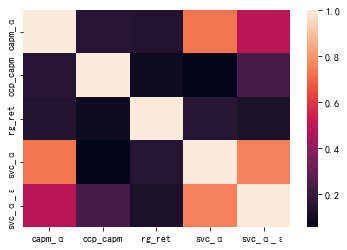

In [42]:
all_factors = {

'capm_α' : all_fund_capm_α,
'svc_α' : all_fund_svc_α, #
# 'capm_α' : all_fund_capm_α_ε,
'svc_α_ε' : all_fund_svc_α_ε, # 
# 'capm_α' : industry_concentration,
# 'capm_α' : active_share,
'ccp_capm' : ccp_capm_it,
# 'capm_α' : ccp_svc_it,
'rg_ret' : rg_ret_t,

}

c_factor_index = list((permutations(all_factors.keys(), 2)))

corrs = pd.Series(index=pd.MultiIndex.from_tuples(c_factor_index), dtype=object)
for keys in c_factor_index:
    corrs.loc[keys[0], keys[1]] = all_factors[keys[0]].corrwith(all_factors[keys[1]]).mean()

display(corrs)
sns.heatmap(corrs.unstack().fillna(1))


In [4]:
svc_source['hs300'] = svc_source.hs300.pct_change()
svc_source.dropna(inplace=True)

In [5]:
from data.TwoStepData.fees import fees
fees = fees.unstack().resample('M').last().fillna(0)

In [6]:
return_of_all_fund_

Symbol,000001,000011,000017,000021,000029,000030,000039,000056,000057,000058,...,960016,960018,960020,960021,960022,960023,960024,960026,960028,960033
Date,,,,,,,,,,,,,,,,,,,,,
2005-06,0.021018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-07,0.009751,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-08,0.020386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-09,0.005258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-10,-0.030335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07,-0.007456,-0.052414,-0.066747,-0.016355,0.000912,-0.031532,-0.037648,-0.059038,-0.068323,-0.021427,...,-0.002058,-0.029071,-0.029570,-0.096210,NaN,NaN,-0.066415,NaN,-0.095397,NaN
2022-08,-0.017840,-0.050224,-0.047036,-0.039701,-0.035248,-0.082660,-0.076674,-0.025174,-0.041778,0.001284,...,-0.027416,-0.011065,-0.048015,-0.035484,NaN,NaN,-0.036527,NaN,-0.021346,NaN
2022-09,-0.004780,-0.062125,-0.066261,-0.067138,-0.049764,-0.058472,-0.071711,-0.043306,-0.056122,-0.015524,...,-0.034619,-0.036639,-0.045587,-0.060870,NaN,NaN,-0.043802,NaN,-0.019719,NaN


,monthly sharpe,annual sharpe,monthly std,annual std,β,monthly α,annual α,6 month MDD,win rate,5% ES,compounded annual return,excess compounded annual return,last month,last 3 months,last 6 months,cumulative all,past year,past 3 year p.a.,past 5 year p.a.,past 10 year p.a.
沪深300,0.081901,0.283714,0.083527,0.289346,1.034931,-0.08%,-0.95%,-117.07%,50.51%,-19.38%,6.52%,4.11%,9.81%,-5.54%,-5.83%,282.18%,-20.26%,0.21%,-0.78%,6.06%
Top 3,0.171614,0.594488,0.075863,0.262799,0.810552,0.75%,9.36%,-60.12%,56.06%,-15.9%,15.48%,12.97%,-3.83%,-7.72%,-4.73%,1075.25%,-25.4%,15.13%,11.23%,15.01%
3 超额,0.089713,0.310774,-0.007663,-0.026547,-0.224379,0.83%,10.31%,56.95%,5.56%,3.48%,8.96%,8.86%,-13.64%,-2.19%,1.1%,793.07%,-5.14%,14.91%,12.0%,8.95%
Top 5,0.167694,0.580911,0.074091,0.256659,0.821446,0.68%,8.46%,-60.85%,55.05%,-15.77%,14.84%,12.34%,-4.21%,-9.76%,-5.18%,981.26%,-24.87%,19.43%,12.87%,15.06%
5 超额,0.085793,0.297197,-0.009436,-0.032687,-0.213485,0.76%,9.41%,56.22%,4.55%,3.61%,8.32%,8.23%,-14.02%,-4.22%,0.65%,699.08%,-4.61%,19.22%,13.65%,9.0%
Top 10,0.139865,0.484508,0.072625,0.251580,0.827949,0.45%,5.48%,-62.98%,55.05%,-16.48%,11.91%,9.45%,-3.96%,-13.04%,-10.06%,640.58%,-27.71%,12.8%,10.38%,11.4%
10 超额,0.057964,0.200794,-0.010902,-0.037766,-0.206983,0.53%,6.43%,54.1%,4.55%,2.9%,5.39%,5.35%,-13.77%,-7.5%,-4.23%,358.4%,-7.45%,12.58%,11.16%,5.34%


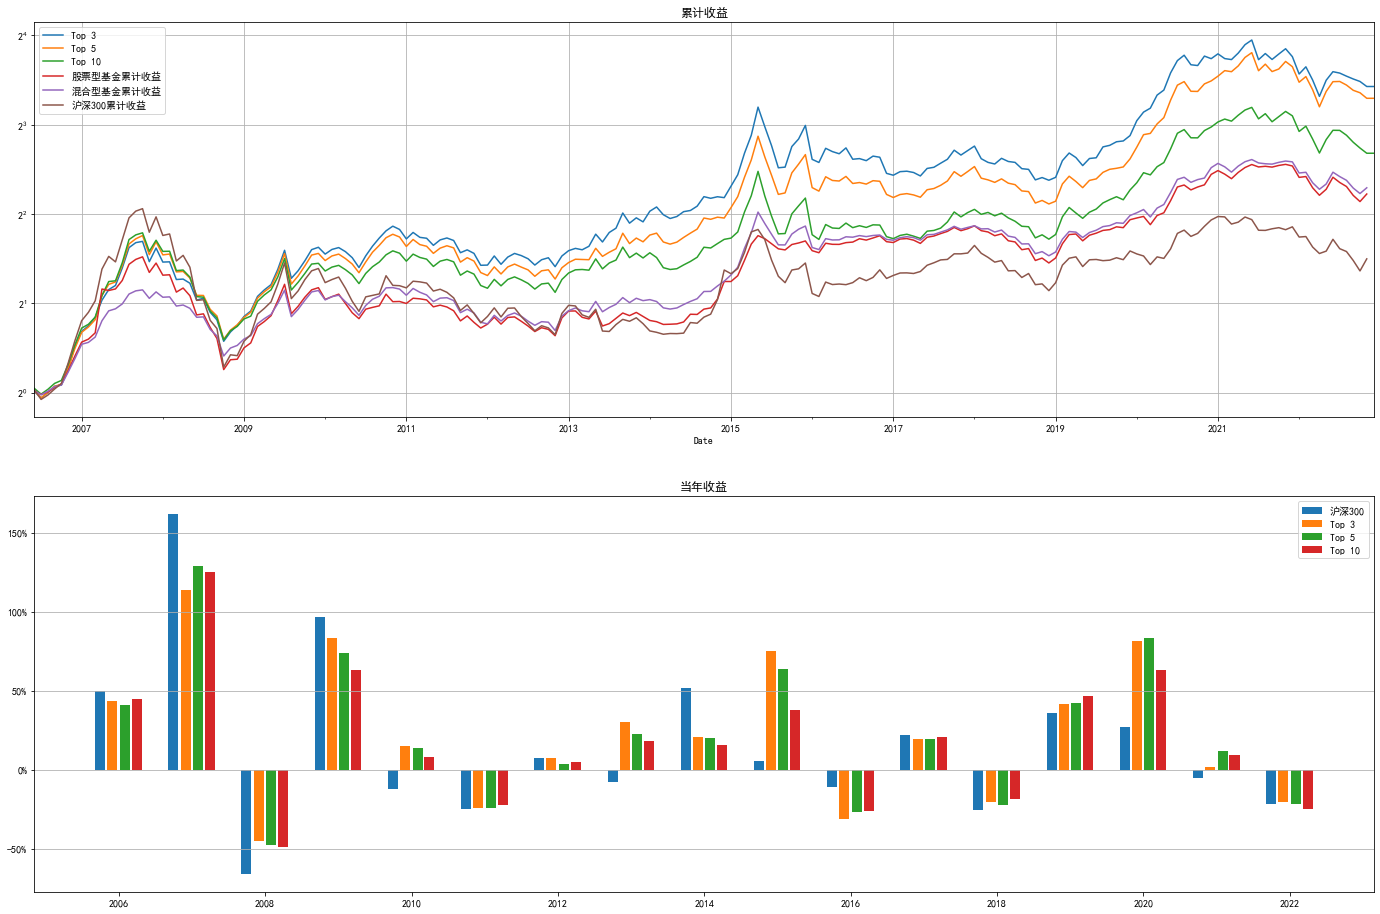

In [6]:
def get_selected_fund_return(date_funds, weighting='1/n'):
    
    date = date_funds.name
    funds = date_funds.values[0]

    if weighting == '1/n':
        return return_of_all_fund_.shift(-1).loc[date, funds].mean()

    elif weighting == 'mkt':
        weights = all_fund_weight.loc[date, funds]
        weights /= weights.sum()

        return (return_of_all_fund_.shift(-1).loc[date, funds] * weights).sum()


def z_score_factors(all_factors, truncate_proportion, ivol_truncate, mkt_truncate, return_truncate, MIN_VALID_NUM):

    concatenated_all_factors = pd.concat(list(map(lambda x: x.loc[start_time: end_time], all_factors.values())))

    concatenated_all_factors = concatenated_all_factors.apply(lambda x:
                                                              x.dropna()[np.logical_and(x.dropna() > x.dropna().quantile(
                                                                  truncate_proportion), x.dropna() < x.dropna().quantile(1 - truncate_proportion))],
                                                              axis=1)
    ivol_condition = return_of_all_fund_.rolling(12).std()
    ivol_condition = pd.notna(ivol_condition.apply(lambda x: x.dropna()[np.logical_and(x.dropna(
    ) > x.dropna().quantile(ivol_truncate), x.dropna() < x.dropna().quantile(1 - ivol_truncate))], axis=1))
    ivol_condition = ivol_condition.stack()[ivol_condition.stack()].index
    mkt_value_condition_ = all_fund_weight > 1e7
    mkt_value_condition_ = mkt_value_condition_.stack(
    )[mkt_value_condition_.stack()].index
    mkt_value_condition = pd.notna(all_fund_weight.apply(
        lambda x: x.dropna()[x.dropna() > x.dropna().quantile(mkt_truncate)], axis=1))
    mkt_value_condition = mkt_value_condition.stack(
    )[mkt_value_condition.stack()].index

    filtered_funds_condition = filtered_funds.stack()[
        filtered_funds.stack()].index

    z_scored_all_factors = concatenated_all_factors.apply(lambda x: zscore(x.dropna())
                                                          if pd.notna(x).sum() >= MIN_VALID_NUM else pd.Series([np.nan] * len(x), index=x.index), axis=1)

    return_condition = pd.notna(return_of_all_fund_.apply(lambda x: x.dropna()[np.logical_and(x.dropna(
    ) > x.dropna().quantile(return_truncate), x.dropna() < x.dropna().quantile(1 - return_truncate))], axis=1))
    return_condition = return_condition.stack()[return_condition.stack()].index

    filtered_index = reduce(lambda x, y: np.intersect1d(x, y),
                            [ivol_condition, mkt_value_condition, mkt_value_condition_, filtered_funds_condition, return_condition, z_scored_all_factors.stack().index])

    z_scored_all_factors = z_scored_all_factors.stack(
    ).loc[filtered_index].groupby(level=[0, 1]).mean()

    assume_tradable_part = z_scored_all_factors.loc[:
                                                    tradable.index[0] - pd.offsets.MonthEnd(1)]
    assume_not_tradable_part = z_scored_all_factors.loc[tradable.index[0]:]
    co_funds = np.intersect1d(
        tradable.columns, assume_not_tradable_part.unstack().columns)
    tradable_ = tradable[co_funds]
    assume_not_tradable_part = assume_not_tradable_part.loc[np.intersect1d(
        assume_not_tradable_part.index, tradable_.stack().index)]
    z_scored_all_factors = pd.concat(
        [assume_tradable_part, assume_not_tradable_part]).unstack()

    return z_scored_all_factors



def test_factors(all_factors, start_time='2005-6', end_time=datetime.datetime.today().strftime('%Y-%m-%d'),
                 truncate_proportion=.01, MIN_VALID_NUM=15, ivol_truncate=.2, mkt_truncate=.2, return_truncate=.01, mdd_month=6, es_proportion=.05):
    '''
    all_factors : list of dicts

    start_time : str
    
    factor test start time

    end_time : str
    
    factor test end time

    truncate_proportion :  float

    handle extreme values in factors

    MIN_VALID_NUM : int

    set NA if fund's one factor do not meet the min valid data requirement

    ivol_truncate : float
    
    handle extreme volatility in funds

    mkt_truncate : float

    handle small market value funds

    return_truncate : float

    handle wrong return data (mainly caused by wrong fund division month)

    mdd_month : int

    rolling month for maximum draw down
    
    es_proportion : float

    the tail proportion for expected shortfall

    '''


    z_scored_all_factors = z_score_factors(all_factors, truncate_proportion, ivol_truncate, mkt_truncate, return_truncate, MIN_VALID_NUM)

    selected_funds = select_funds(z_scored_all_factors, 10)
    funds_return = pd.DataFrame(selected_funds).apply(lambda x: get_selected_fund_return(x, '1/n'), axis=1)
    funds_return.index = funds_return.index + pd.offsets.MonthEnd(1)

    plot_start_time = funds_return.index[0]

    mkt_return = svc_source.loc[plot_start_time:].mktrf + svc_source.loc[plot_start_time:].rf
    fig, axes = plt.subplots(2, 1, figsize=(24, 16))

    statistics = []

    columns = ['monthly sharpe', 'annual sharpe', 'monthly std', 'annual std', 'β', 'monthly α', 'annual α', f'{mdd_month} month MDD', 'win rate',
               f'{int(es_proportion * 100)}% ES', 'compounded annual return', 'excess compounded annual return', 'last month', 'last 3 months', 'last 6 months',
               'cumulative all', 'past year', 'past 3 year p.a.', 'past 5 year p.a.', 'past 10 year p.a.']
    fig1_plot_data = {}
    fig2_plot_data = {}

    for top_num in ['沪深300', 3, 5, 10]:
        if top_num != '沪深300':
            selected_funds = select_funds(z_scored_all_factors, top_num)

            selected_funds.to_excel(f'result/{top_num}/selected_funds.xlsx')

            indexes = []
            for date in selected_funds.index:
                indexes.append(
                    list(zip([date] * len(selected_funds), selected_funds.loc[date])))

            indexes = pd.MultiIndex.from_tuples(
                list(map(lambda x: tuple(x), np.array(indexes).reshape(-1, 2))))
            co_indexes = np.intersect1d(
                invest_industry_proportion.swaplevel().index, indexes)
            selected_funds_allocation = invest_industry_proportion.swaplevel(
            ).loc[co_indexes]
            co_indexes = np.intersect1d(selected_funds_allocation.index,
                                        csmar_stock_fund_weight_yearly.stack().index)
            selected_funds_allocation.loc[co_indexes].multiply(
                csmar_stock_fund_weight_yearly.stack().loc[co_indexes], axis=0)
            selected_funds_allocation = selected_funds_allocation.groupby(
                level=0).sum().resample('y').sum()
            selected_funds_allocation = selected_funds_allocation.div(
                selected_funds_allocation.sum(axis=1), axis=0)
            selected_funds_allocation.to_excel(
                f'result/{top_num}/selected_funds_allocation.xlsx')

            funds_return = pd.DataFrame(selected_funds).apply(
                lambda x: get_selected_fund_return(x, 'mkt'), axis=1)
            funds_return.index = funds_return.index + pd.offsets.MonthEnd(1)
            funds_return.to_excel(f'result/{top_num}/funds_return.xlsx')

        elif top_num == '沪深300':
            funds_return = svc_source.loc[plot_start_time:].hs300

        co_index = np.intersect1d(funds_return.index, mkt_return.index)
        regression = sm.OLS(funds_return.loc[co_index], sm.add_constant(mkt_return).loc[co_index]).fit().params
        α = regression.iloc[0]
        annual_α = (α + 1) ** 12 - 1
        β = regression.iloc[1]
        annual_return = (funds_return + 1).cumprod().iloc[-1] ** (
            1 / ((funds_return.index[-1] - funds_return.index[0]).n / 12)) - 1
        excess_return = funds_return.loc[co_index] - \
            svc_source.loc[plot_start_time:].rf.loc[co_index]
        excess_annual_return = (excess_return + 1).cumprod().iloc[-1] ** (
            1 / ((excess_return.index[-1] - excess_return.index[0]).n / 12)) - 1
        sharpe = excess_return.mean() / excess_return.std()
        # excess_return_ = excess_return.resample('y').apply(lambda x: (1 + x).cumprod()[-1] - 1)
        annual_sharpe = np.sqrt(12) * sharpe
        mdd = (funds_return + 1).cumprod().rolling(mdd_month).apply(lambda x: (
            x[-1] - x.max())/x[-1]).replace([np.inf, -np.inf], np.nan).dropna().min()
        monthly_std = funds_return.std()
        annual_std = np.sqrt(12) * funds_return.std()
        es_proportional = funds_return.sort_values()[: int(
            es_proportion * len(funds_return))].mean()
        win_rate = (funds_return.loc[co_index] >
                    mkt_return.loc[co_index]).sum() / len(co_index)
        last_month = funds_return.loc[(
            datetime.datetime.now() - pd.offsets.MonthEnd(1)).to_period('M')]
        last_3_month = ((funds_return.loc[(datetime.datetime.now() - pd.offsets.MonthEnd(3)).to_period('M'): (
            datetime.datetime.now() - pd.offsets.MonthEnd(1)).to_period('M')] + 1).cumprod() - 1).iloc[-1]
        last_6_month = ((funds_return.loc[(datetime.datetime.now() - pd.offsets.MonthEnd(6)).to_period('M'): (
            datetime.datetime.now() - pd.offsets.MonthEnd(1)).to_period('M')] + 1).cumprod() - 1).iloc[-1]
        cumulative_all = (funds_return + 1).cumprod().iloc[-1]
        #
        past_year = ((funds_return.loc[(datetime.datetime.now() - pd.offsets.MonthEnd(12)).to_period('M'): (
            datetime.datetime.now() - pd.offsets.MonthEnd(1)).to_period('M')] + 1).cumprod() - 1).iloc[-1]
        past_3_year = ((funds_return.loc[(datetime.datetime.now() - pd.offsets.MonthEnd(36)).to_period('M'): (
            datetime.datetime.now() - pd.offsets.MonthEnd(1)).to_period('M')] + 1).cumprod() - 1).iloc[-1]
        annual_past_3_year = ((past_3_year + 1) ** (1 / 3)) - 1
        past_5_year = ((funds_return.loc[(datetime.datetime.now() - pd.offsets.MonthEnd(60)).to_period('M'): (
            datetime.datetime.now() - pd.offsets.MonthEnd(1)).to_period('M')] + 1).cumprod() - 1).iloc[-1]
        annual_past_5_year = ((past_5_year + 1) ** (1 / 5)) - 1
        past_10_year = ((funds_return.loc[(datetime.datetime.now() - pd.offsets.MonthEnd(120)).to_period('M'): (
            datetime.datetime.now() - pd.offsets.MonthEnd(1)).to_period('M')] + 1).cumprod() - 1).iloc[-1]
        annual_past_10_year = ((past_10_year + 1) ** (1 / 10)) - 1

        statistics.append([sharpe, annual_sharpe, monthly_std, annual_std, β, α, annual_α, mdd,
                           win_rate, es_proportional, annual_return, excess_annual_return,
                           last_month, last_3_month, last_6_month, cumulative_all, past_year,
                           annual_past_3_year, annual_past_5_year, annual_past_10_year])

        pd.DataFrame(statistics).to_excel(
            f'result/{top_num}/statistics.xlsx')

        if top_num != '沪深300':

            ax1 = axes[0]
            ax1.set_yscale('log', base=2)
            cumulative_return = (funds_return + 1).cumprod()

            cumulative_return.to_excel(
                f'result/{top_num}/cumulative_return.xlsx')

            cumulative_return.plot(label=f'Top {top_num}', ax=axes[0])
            fig1_plot_data[f'Top {top_num}'] = cumulative_return

        per_year_return = funds_return.resample('y').apply(
            lambda x: (x + 1).cumprod().iloc[-1] - 1)
        per_year_return.to_excel(f'result/{top_num}/per_year_return.xlsx')

        ax2 = axes[1]
        if top_num != '沪深300':
            ax2.bar(per_year_return.index.to_timestamp() - pd.offsets.MonthEnd(6) + pd.offsets.MonthEnd(2 * len(statistics)),
                    per_year_return.values * 100, width=50, label=f'Top {top_num}')
            fig2_plot_data[f'Top {top_num}'] = per_year_return
        else:
            ax2.bar(per_year_return.index.to_timestamp() - pd.offsets.MonthEnd(6) + pd.offsets.MonthEnd(2 * len(statistics)),
                    per_year_return.values * 100, width=50, label='沪深300')
            fig2_plot_data['沪深300'] = per_year_return

    table = pd.DataFrame(statistics, index=[
                         '沪深300'] + [f'Top {top_num}' for top_num in [3, 5, 10]], columns=columns)
    difference = table.iloc[1:] - table.iloc[0]
    difference.index = [f'{top_num} 超额' for top_num in [3, 5, 10]]
    table = pd.concat([table, difference])
    table[columns[5:]] = (table[columns[5:]] * 100).round(2).astype(str) + '%'
    table = table.reindex(
        ['沪深300', 'Top 3', '3 超额', 'Top 5', '5 超额', 'Top 10', '10 超额'])
    display(table)
    table.to_excel('result/table.xlsx')

    ((return_of_csmar_stock_fund.unstack().T.dropna(how='all').sort_index() * csmar_stock_fund_weight_yearly.sort_index()
      ).sum(axis=1) + 1).loc[plot_start_time:].cumprod().plot(label='股票型基金累计收益', ax=axes[0])
    ((return_of_csmar_blend_fund.unstack().T.dropna(how='all').sort_index() * csmar_blend_fund_weight_yearly.sort_index()
      ).sum(axis=1) + 1).loc[plot_start_time:].cumprod().plot(label='混合型基金累计收益', ax=axes[0])
    (svc_source.loc[plot_start_time:].hs300 +
        1).cumprod().plot(label='沪深300累计收益', ax=axes[0])
    fig1_plot_data['股票型基金'] = ((return_of_csmar_stock_fund.unstack().T.dropna(how='all').sort_index() * csmar_stock_fund_weight_yearly.sort_index()
                                ).sum(axis=1) + 1).loc[plot_start_time:].cumprod()
    fig1_plot_data['混合型基金'] = ((return_of_csmar_blend_fund.unstack().T.dropna(how='all').sort_index() * csmar_blend_fund_weight_yearly.sort_index()
                                ).sum(axis=1) + 1).loc[plot_start_time:].cumprod()
    fig1_plot_data['沪深300'] = (
        svc_source.hs300 + 1).loc[plot_start_time:].cumprod()

    fig1 = pd.concat(fig1_plot_data, axis=1)
    fig1.index = fig1.index.astype(str)
    fig2 = pd.concat(fig2_plot_data, axis=1)
    fig2.index = fig2.index.astype(str)
    fig1.to_excel('result/fig1.xlsx')
    fig2.to_excel('result/fig2.xlsx')

    ax1.grid()
    ax2.grid(axis='y')
    ax1.legend()
    ax1.set_title('累计收益')
    ax2.legend()
    ax2.yaxis.set_major_formatter(ticker.PercentFormatter())
    ax2.set_title('当年收益')
    plt.savefig('result/demo.png', transparent=True)
    plt.show()

    return selected_funds

svc_α = test_factors({'svc_α': all_fund_svc_α}, start_time='2012-1',
                     end_time=datetime.datetime.today().strftime('%Y-%m-%d'), mdd_month=6)


,monthly sharpe,annual sharpe,monthly std,annual std,β,monthly α,annual α,6 month MDD,win rate,5% ES,compounded annual return,excess compounded annual return,last month,last 3 months,last 6 months,cumulative all,past year,past 3 year p.a.,past 5 year p.a.,past 10 year p.a.
沪深300,0.081901,0.283714,0.083527,0.289346,1.034931,-0.08%,-0.95%,-117.07%,50.51%,-19.38%,6.52%,4.11%,9.81%,-5.54%,-5.83%,282.18%,-20.26%,0.21%,-0.78%,6.06%
Top 3,0.171614,0.594488,0.075863,0.262799,0.810552,0.75%,9.36%,-60.12%,56.06%,-15.9%,15.48%,12.97%,-3.83%,-7.72%,-4.73%,1075.25%,-25.4%,15.13%,11.23%,15.01%
3 超额,0.089713,0.310774,-0.007663,-0.026547,-0.224379,0.83%,10.31%,56.95%,5.56%,3.48%,8.96%,8.86%,-13.64%,-2.19%,1.1%,793.07%,-5.14%,14.91%,12.0%,8.95%
Top 5,0.167694,0.580911,0.074091,0.256659,0.821446,0.68%,8.46%,-60.85%,55.05%,-15.77%,14.84%,12.34%,-4.21%,-9.76%,-5.18%,981.26%,-24.87%,19.43%,12.87%,15.06%
5 超额,0.085793,0.297197,-0.009436,-0.032687,-0.213485,0.76%,9.41%,56.22%,4.55%,3.61%,8.32%,8.23%,-14.02%,-4.22%,0.65%,699.08%,-4.61%,19.22%,13.65%,9.0%
Top 10,0.139865,0.484508,0.072625,0.251580,0.827949,0.45%,5.48%,-62.98%,55.05%,-16.48%,11.91%,9.45%,-3.96%,-13.04%,-10.06%,640.58%,-27.71%,12.8%,10.38%,11.4%
10 超额,0.057964,0.200794,-0.010902,-0.037766,-0.206983,0.53%,6.43%,54.1%,4.55%,2.9%,5.39%,5.35%,-13.77%,-7.5%,-4.23%,358.4%,-7.45%,12.58%,11.16%,5.34%


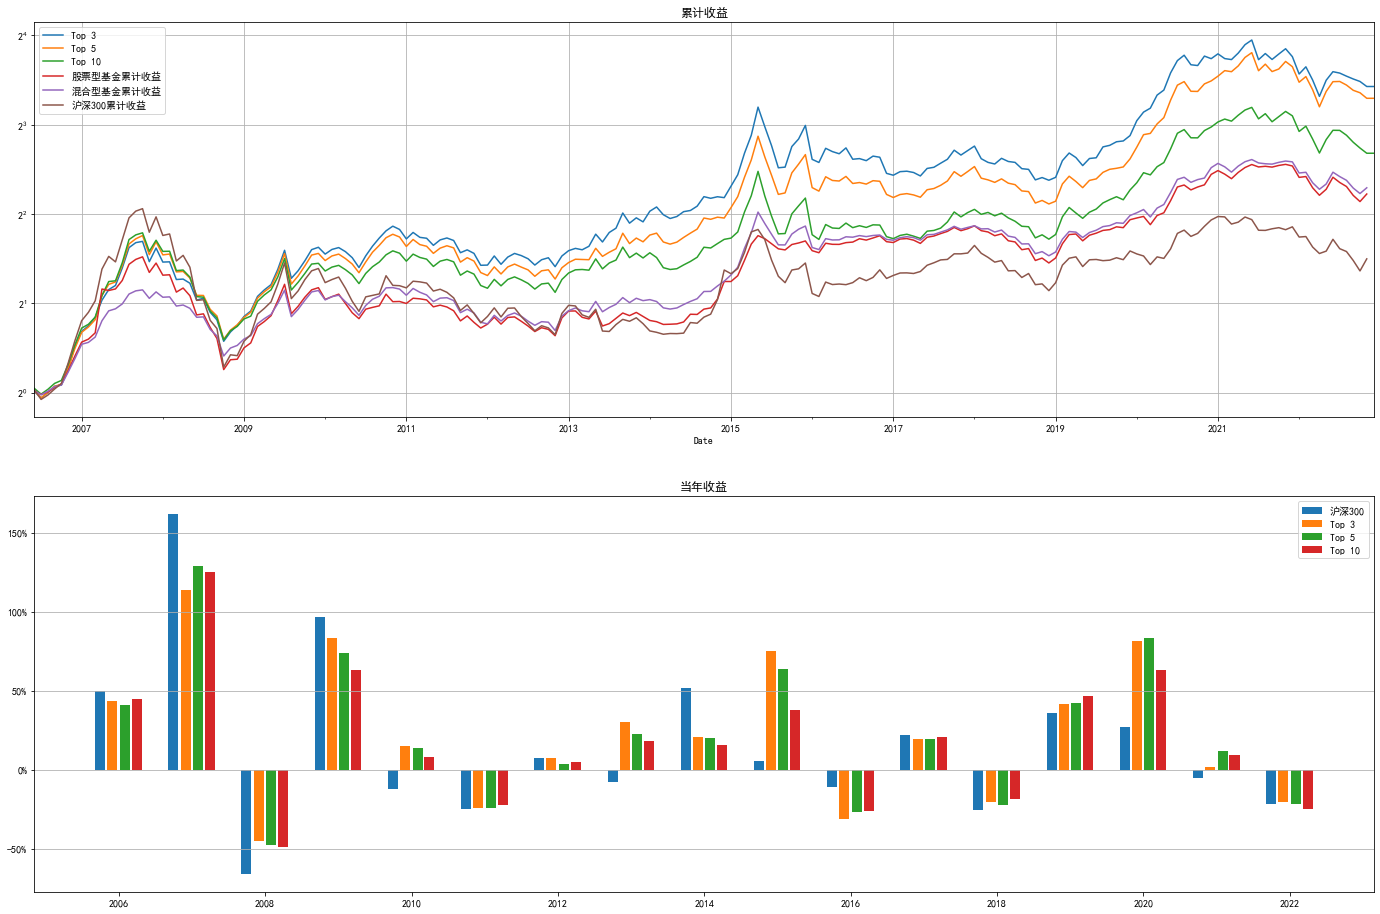

In [11]:
def get_selected_fund_return(date_funds, weighting='1/n'):
    
    date = date_funds.name
    funds = date_funds.values[0]

    if weighting == '1/n':
        return return_of_all_fund_.shift(-1).loc[date, funds].mean()

    elif weighting == 'mkt':
        weights = all_fund_weight.loc[date, funds]
        weights /= weights.sum()

        return (return_of_all_fund_.shift(-1).loc[date, funds] * weights).sum()


def z_score_factors(all_factors, truncate_proportion, ivol_truncate, mkt_truncate, return_truncate, MIN_VALID_NUM):

    concatenated_all_factors = pd.concat(list(map(lambda x: x.loc[start_time: end_time], all_factors.values())))

    concatenated_all_factors = concatenated_all_factors.apply(lambda x:
                                                              x.dropna()[np.logical_and(x.dropna() > x.dropna().quantile(
                                                                  truncate_proportion), x.dropna() < x.dropna().quantile(1 - truncate_proportion))],
                                                              axis=1)
    ivol_condition = return_of_all_fund_.rolling(12).std()
    ivol_condition = pd.notna(ivol_condition.apply(lambda x: x.dropna()[np.logical_and(x.dropna(
    ) > x.dropna().quantile(ivol_truncate), x.dropna() < x.dropna().quantile(1 - ivol_truncate))], axis=1))
    ivol_condition = ivol_condition.stack()[ivol_condition.stack()].index
    mkt_value_condition_ = all_fund_weight > 1e7
    mkt_value_condition_ = mkt_value_condition_.stack(
    )[mkt_value_condition_.stack()].index
    mkt_value_condition = pd.notna(all_fund_weight.apply(
        lambda x: x.dropna()[x.dropna() > x.dropna().quantile(mkt_truncate)], axis=1))
    mkt_value_condition = mkt_value_condition.stack(
    )[mkt_value_condition.stack()].index

    filtered_funds_condition = filtered_funds.stack()[
        filtered_funds.stack()].index

    z_scored_all_factors = concatenated_all_factors.apply(lambda x: zscore(x.dropna())
                                                          if pd.notna(x).sum() >= MIN_VALID_NUM else pd.Series([np.nan] * len(x), index=x.index), axis=1)

    return_condition = pd.notna(return_of_all_fund_.apply(lambda x: x.dropna()[np.logical_and(x.dropna(
    ) > x.dropna().quantile(return_truncate), x.dropna() < x.dropna().quantile(1 - return_truncate))], axis=1))
    return_condition = return_condition.stack()[return_condition.stack()].index

    filtered_index = reduce(lambda x, y: np.intersect1d(x, y),
                            [ivol_condition, mkt_value_condition, mkt_value_condition_, filtered_funds_condition, return_condition, z_scored_all_factors.stack().index])

    z_scored_all_factors = z_scored_all_factors.stack(
    ).loc[filtered_index].groupby(level=[0, 1]).mean()

    assume_tradable_part = z_scored_all_factors.loc[:
                                                    tradable.index[0] - pd.offsets.MonthEnd(1)]
    assume_not_tradable_part = z_scored_all_factors.loc[tradable.index[0]:]
    co_funds = np.intersect1d(
        tradable.columns, assume_not_tradable_part.unstack().columns)
    tradable_ = tradable[co_funds]
    assume_not_tradable_part = assume_not_tradable_part.loc[np.intersect1d(
        assume_not_tradable_part.index, tradable_.stack().index)]
    z_scored_all_factors = pd.concat(
        [assume_tradable_part, assume_not_tradable_part]).unstack()

    return z_scored_all_factors



def test_factors(all_factors, start_time='2005-6', end_time=datetime.datetime.today().strftime('%Y-%m-%d'),
                 truncate_proportion=.01, MIN_VALID_NUM=15, ivol_truncate=.2, mkt_truncate=.2, return_truncate=.01, mdd_month=6, es_proportion=.05):
    '''
    all_factors : list of dicts

    start_time : str
    
    factor test start time

    end_time : str
    
    factor test end time

    truncate_proportion :  float

    handle extreme values in factors

    MIN_VALID_NUM : int

    set NA if fund's one factor do not meet the min valid data requirement

    ivol_truncate : float
    
    handle extreme volatility in funds

    mkt_truncate : float

    handle small market value funds

    return_truncate : float

    handle wrong return data (mainly caused by wrong fund division month)

    mdd_month : int

    rolling month for maximum draw down
    
    es_proportion : float

    the tail proportion for expected shortfall

    '''


    z_scored_all_factors = z_score_factors(all_factors, truncate_proportion, ivol_truncate, mkt_truncate, return_truncate, MIN_VALID_NUM)

    selected_funds = select_funds(z_scored_all_factors, 10)
    funds_return = pd.DataFrame(selected_funds).apply(lambda x: get_selected_fund_return(x, '1/n'), axis=1)
    funds_return.index = funds_return.index + pd.offsets.MonthEnd(1)

    plot_start_time = funds_return.index[0]

    mkt_return = svc_source.loc[plot_start_time:].mktrf + svc_source.loc[plot_start_time:].rf
    fig, axes = plt.subplots(2, 1, figsize=(24, 16))

    statistics = []

    columns = ['monthly sharpe', 'annual sharpe', 'monthly std', 'annual std', 'β', 'monthly α', 'annual α', f'{mdd_month} month MDD', 'win rate',
               f'{int(es_proportion * 100)}% ES', 'compounded annual return', 'excess compounded annual return', 'last month', 'last 3 months', 'last 6 months',
               'cumulative all', 'past year', 'past 3 year p.a.', 'past 5 year p.a.', 'past 10 year p.a.']
    fig1_plot_data = {}
    fig2_plot_data = {}

    for top_num in ['沪深300', 3, 5, 10]:
        if top_num != '沪深300':
            selected_funds = select_funds(z_scored_all_factors, top_num)

            selected_funds.to_excel(f'result/{top_num}/selected_funds.xlsx')

            indexes = []
            for date in selected_funds.index:
                indexes.append(
                    list(zip([date] * len(selected_funds), selected_funds.loc[date])))

            indexes = pd.MultiIndex.from_tuples(
                list(map(lambda x: tuple(x), np.array(indexes).reshape(-1, 2))))
            co_indexes = np.intersect1d(
                invest_industry_proportion.swaplevel().index, indexes)
            selected_funds_allocation = invest_industry_proportion.swaplevel(
            ).loc[co_indexes]
            co_indexes = np.intersect1d(selected_funds_allocation.index,
                                        csmar_stock_fund_weight_yearly.stack().index)
            selected_funds_allocation.loc[co_indexes].multiply(
                csmar_stock_fund_weight_yearly.stack().loc[co_indexes], axis=0)
            selected_funds_allocation = selected_funds_allocation.groupby(
                level=0).sum().resample('y').sum()
            selected_funds_allocation = selected_funds_allocation.div(
                selected_funds_allocation.sum(axis=1), axis=0)
            selected_funds_allocation.to_excel(
                f'result/{top_num}/selected_funds_allocation.xlsx')

            funds_return = pd.DataFrame(selected_funds).apply(
                lambda x: get_selected_fund_return(x, 'mkt'), axis=1)
            funds_return.index = funds_return.index + pd.offsets.MonthEnd(1)
            funds_return.to_excel(f'result/{top_num}/funds_return.xlsx')

        elif top_num == '沪深300':
            funds_return = svc_source.loc[plot_start_time:].hs300

        co_index = np.intersect1d(funds_return.index, mkt_return.index)
        regression = sm.OLS(funds_return.loc[co_index], sm.add_constant(mkt_return).loc[co_index]).fit().params
        α = regression.iloc[0]
        annual_α = (α + 1) ** 12 - 1
        β = regression.iloc[1]
        annual_return = (funds_return + 1).cumprod().iloc[-1] ** (
            1 / ((funds_return.index[-1] - funds_return.index[0]).n / 12)) - 1
        excess_return = funds_return.loc[co_index] - \
            svc_source.loc[plot_start_time:].rf.loc[co_index]
        excess_annual_return = (excess_return + 1).cumprod().iloc[-1] ** (
            1 / ((excess_return.index[-1] - excess_return.index[0]).n / 12)) - 1
        sharpe = excess_return.mean() / excess_return.std()
        # excess_return_ = excess_return.resample('y').apply(lambda x: (1 + x).cumprod()[-1] - 1)
        annual_sharpe = np.sqrt(12) * sharpe
        mdd = (funds_return + 1).cumprod().rolling(mdd_month).apply(lambda x: (
            x[-1] - x.max())/x[-1]).replace([np.inf, -np.inf], np.nan).dropna().min()
        monthly_std = funds_return.std()
        annual_std = np.sqrt(12) * funds_return.std()
        es_proportional = funds_return.sort_values()[: int(
            es_proportion * len(funds_return))].mean()
        win_rate = (funds_return.loc[co_index] >
                    mkt_return.loc[co_index]).sum() / len(co_index)
        last_month = funds_return.loc[(
            datetime.datetime.now() - pd.offsets.MonthEnd(1)).to_period('M')]
        last_3_month = ((funds_return.loc[(datetime.datetime.now() - pd.offsets.MonthEnd(3)).to_period('M'): (
            datetime.datetime.now() - pd.offsets.MonthEnd(1)).to_period('M')] + 1).cumprod() - 1).iloc[-1]
        last_6_month = ((funds_return.loc[(datetime.datetime.now() - pd.offsets.MonthEnd(6)).to_period('M'): (
            datetime.datetime.now() - pd.offsets.MonthEnd(1)).to_period('M')] + 1).cumprod() - 1).iloc[-1]
        cumulative_all = (funds_return + 1).cumprod().iloc[-1]
        #
        past_year = ((funds_return.loc[(datetime.datetime.now() - pd.offsets.MonthEnd(12)).to_period('M'): (
            datetime.datetime.now() - pd.offsets.MonthEnd(1)).to_period('M')] + 1).cumprod() - 1).iloc[-1]
        past_3_year = ((funds_return.loc[(datetime.datetime.now() - pd.offsets.MonthEnd(36)).to_period('M'): (
            datetime.datetime.now() - pd.offsets.MonthEnd(1)).to_period('M')] + 1).cumprod() - 1).iloc[-1]
        annual_past_3_year = ((past_3_year + 1) ** (1 / 3)) - 1
        past_5_year = ((funds_return.loc[(datetime.datetime.now() - pd.offsets.MonthEnd(60)).to_period('M'): (
            datetime.datetime.now() - pd.offsets.MonthEnd(1)).to_period('M')] + 1).cumprod() - 1).iloc[-1]
        annual_past_5_year = ((past_5_year + 1) ** (1 / 5)) - 1
        past_10_year = ((funds_return.loc[(datetime.datetime.now() - pd.offsets.MonthEnd(120)).to_period('M'): (
            datetime.datetime.now() - pd.offsets.MonthEnd(1)).to_period('M')] + 1).cumprod() - 1).iloc[-1]
        annual_past_10_year = ((past_10_year + 1) ** (1 / 10)) - 1

        statistics.append([sharpe, annual_sharpe, monthly_std, annual_std, β, α, annual_α, mdd,
                           win_rate, es_proportional, annual_return, excess_annual_return,
                           last_month, last_3_month, last_6_month, cumulative_all, past_year,
                           annual_past_3_year, annual_past_5_year, annual_past_10_year])

        pd.DataFrame(statistics).to_excel(
            f'result/{top_num}/statistics.xlsx')

        if top_num != '沪深300':

            ax1 = axes[0]
            ax1.set_yscale('log', base=2)
            cumulative_return = (funds_return + 1).cumprod()

            cumulative_return.to_excel(
                f'result/{top_num}/cumulative_return.xlsx')

            cumulative_return.plot(label=f'Top {top_num}', ax=axes[0])
            fig1_plot_data[f'Top {top_num}'] = cumulative_return

        per_year_return = funds_return.resample('y').apply(
            lambda x: (x + 1).cumprod().iloc[-1] - 1)
        per_year_return.to_excel(f'result/{top_num}/per_year_return.xlsx')

        ax2 = axes[1]
        if top_num != '沪深300':
            ax2.bar(per_year_return.index.to_timestamp() - pd.offsets.MonthEnd(6) + pd.offsets.MonthEnd(2 * len(statistics)),
                    per_year_return.values * 100, width=50, label=f'Top {top_num}')
            fig2_plot_data[f'Top {top_num}'] = per_year_return
        else:
            ax2.bar(per_year_return.index.to_timestamp() - pd.offsets.MonthEnd(6) + pd.offsets.MonthEnd(2 * len(statistics)),
                    per_year_return.values * 100, width=50, label='沪深300')
            fig2_plot_data['沪深300'] = per_year_return

    table = pd.DataFrame(statistics, index=[
                         '沪深300'] + [f'Top {top_num}' for top_num in [3, 5, 10]], columns=columns)
    difference = table.iloc[1:] - table.iloc[0]
    difference.index = [f'{top_num} 超额' for top_num in [3, 5, 10]]
    table = pd.concat([table, difference])
    table[columns[5:]] = (table[columns[5:]] * 100).round(2).astype(str) + '%'
    table = table.reindex(
        ['沪深300', 'Top 3', '3 超额', 'Top 5', '5 超额', 'Top 10', '10 超额'])
    display(table)
    table.to_excel('result/table.xlsx')

    ((return_of_csmar_stock_fund.unstack().T.dropna(how='all').sort_index() * csmar_stock_fund_weight_yearly.sort_index()
      ).sum(axis=1) + 1).loc[plot_start_time:].cumprod().plot(label='股票型基金累计收益', ax=axes[0])
    ((return_of_csmar_blend_fund.unstack().T.dropna(how='all').sort_index() * csmar_blend_fund_weight_yearly.sort_index()
      ).sum(axis=1) + 1).loc[plot_start_time:].cumprod().plot(label='混合型基金累计收益', ax=axes[0])
    (svc_source.loc[plot_start_time:].hs300 +
        1).cumprod().plot(label='沪深300累计收益', ax=axes[0])
    fig1_plot_data['股票型基金'] = ((return_of_csmar_stock_fund.unstack().T.dropna(how='all').sort_index() * csmar_stock_fund_weight_yearly.sort_index()
                                ).sum(axis=1) + 1).loc[plot_start_time:].cumprod()
    fig1_plot_data['混合型基金'] = ((return_of_csmar_blend_fund.unstack().T.dropna(how='all').sort_index() * csmar_blend_fund_weight_yearly.sort_index()
                                ).sum(axis=1) + 1).loc[plot_start_time:].cumprod()
    fig1_plot_data['沪深300'] = (
        svc_source.hs300 + 1).loc[plot_start_time:].cumprod()

    fig1 = pd.concat(fig1_plot_data, axis=1)
    fig1.index = fig1.index.astype(str)
    fig2 = pd.concat(fig2_plot_data, axis=1)
    fig2.index = fig2.index.astype(str)
    fig1.to_excel('result/fig1.xlsx')
    fig2.to_excel('result/fig2.xlsx')

    ax1.grid()
    ax2.grid(axis='y')
    ax1.legend()
    ax1.set_title('累计收益')
    ax2.legend()
    ax2.yaxis.set_major_formatter(ticker.PercentFormatter())
    ax2.set_title('当年收益')
    plt.savefig('result/demo.png', transparent=True)
    plt.show()

    return selected_funds

svc_α = test_factors({'svc_α': all_fund_svc_α}, start_time='2012-1',
                     end_time=datetime.datetime.today().strftime('%Y-%m-%d'), mdd_month=6)
